<img align="right" style="max-width: 200px; height: auto" src="./fs_logo.png">

##  Lab 06 - Adversarial Deep Learning

Seminar Künstliche Intelligenz, Frankfurt School, 2022

Die Analysen des Seminars **Künstliche Intelligenz** des Zertifikatstudiengangs **Certified Audit Data Scientist (CADS)** basieren auf Jupyter Notebook. Anhand solcher Notebooks ist es möglich eine Vielzahl von Datenanalysen und statistischen Validierungen durchzuführen.

<img align="center" style="max-width: 700px" src="./lab_06_banner.png">

Im letzten Lab haben Sie die verschiedenen Elemente eines Unsupervised Deep Learning Workflow kennengelernt z.B. Datenaufbereitung, Modell Training und Modell Validierung. In diesem sechsten Lab werden wir Jupyter Notebook verwenden, um ein weiteres **Deep Learning basiertes Audit-Analyseverfahren** zu implementieren und anzuwenden.

Hierzu werden wir die im Seminar vorgestellten Adversarial Autoencoder Neural Networks (Ad-AENNs) anwenden um (1) zunächst die generativen Prozesse einer Finanzbuchhaltung und (2) anschliessend entsprechende Prozessanomalien zu detektieren. Im Gegensatz zu klassischen Autoencoder Netzen lernen AENNs, die Eingabedaten in eine niedrig-dimensionale Repräsentation zu **encodieren**.  Gleichzeitig lernt das AENN, die ursprünglichen Daten wieder aus der enkodierten Repräsentation zu **dekodieren**. 

Die dekodierten Daten, die in der Regel als **Rekonstruktion** bezeichnet werden, sollten eine grosse Ähnlichkeit zu den ursprünglichen **Eingabedaten** aufweisen. Die Buchungssätze, für welche eine erfolgreiche Rekonstruktion nur fehlerhaft gelingt müssen deshalb eine oder mehrere ungewöhnliche Eigenschaften aufweisen. Die nachstehende Abbildung zeigt einen Überblick über den Deep Learning Prozess bzw. die AENN Netzarchitektur, welche wir in diesem Lab implementieren.

<img align="center" style="max-width: 900px" src="./process.png">

Im Rahmen des Lab werden wir wieder einige Funktionen der `PyTorch` Bibliothek nutzen, um das AENN zu implementieren und zu trainieren. Im Laufe des Trainingsprozess soll das AENN die charakteristische Eigenschaften historischer **Buchungen** bzw. **Journal Entries** lernen. Nach erfolgreichen Modelltraining, werden wir das Modell anwenden, um anhand des Rekonstruktionsfehlers ungewöhnliche Buchungen innerhalb des Datensatzes zu detektieren. Abschliessend werden wir die gelernten **Repräsentationen** der einzelnen Journaleinträge dazu verwenden, um die erhaltenen Ergebnisse noch aussagekräftiger zu interpretieren.

Bei etwaigen Fragen wenden Sie sich, wie immer gerne an uns via **marco (dot) schreyer (at) unisg (dot) ch**. Wir wünschen Ihnen Viel Freude mit unseren Notebooks und Ihren revisorischen Analysen!

## Lernziele des Labs:

Nach der heutigen Übung sollten Sie in der Lage sein:

>1. Die **Grundkonzepte, Funktionsweise und Bestandteile** von Adversarial Autoencoder Netzen zu verstehen.
>2. Eine **Vorverarbeitung** von kategorischen Finanzdaten (d.h. One-Hot Encoding und Min-Max Normalisierung) durchzuführen. 
>3. Adversarial Autoencoder Netze anzuwenden, um **Anomalien** in umfangreichen Finanzdaten aufzuspüren.
>4. Die **Ergebnisse** bzw. den Latenten Raum von Adversarial Autoencoder Netzen zu interpretieren.

## 1. Einrichten der Analyseumgebung

Ähnlich wie in den vorangegangenen Übungen werden wir zunächst eine Reihe von Python-Bibliotheken importieren, welche die Datenanalyse und -visualisierung ermöglichen. In dieser Übung werden wir die Bibliotheken `PyTorch`, `Pandas`, `Numpy`, `Scikit-Learn`, `Matplotlib` und `Seaborn` verwenden. Nachfolgend importieren wir die benötigten Bibliotheken durch die Ausführung der folgenden Anweisungen:

In [1]:
# import python data science and utility libraries
import os, sys, itertools, urllib, io, warnings
import datetime as dt
import pandas as pd
import pandas_datareader as dr
import numpy as np

Import der `PyTorch` Deep Learning Bibliotheken:

In [2]:
# pytorch libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils import data
from torch.utils.data import dataloader

/usr/local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Import der `Matplotlib` und `Seaborn` Visualisierungs Bibliotheken und setzen der Visualisierungsparameter:

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = [10, 5]
plt.rcParams['figure.dpi']= 150

/var/folders/pt/jww8lsls64d06ktzyr_p0ww00000gn/T/ipykernel_99766/3264773936.py:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


Ausschalten möglicher Warnmeldungen z.B. aufgrund von zukünftigen Änderungen der Bibliotheken:

In [4]:
# set the warning filter flag to ignore warnings
warnings.filterwarnings('ignore')

Aktivieren der sog. Inline-Darstellung von Visualisierungen in Jupyter-Notebook:

In [5]:
%matplotlib inline

Erstellen von Unterverzeichnissen innerhalb des aktuellen Arbeitsverzeichnisses für (1) das Speichern der Originaldaten, (2) der Analyseergebnisse und (3) der trainierten Modelle:

In [6]:
# create the data sub-directory
data_directory = './01_data'
if not os.path.exists(data_directory): os.makedirs(data_directory)
    
# create the results sub-directory
results_directory = './02_results'
if not os.path.exists(results_directory): os.makedirs(results_directory)

# create the models sub-directory
models_directory = './03_models'
if not os.path.exists(models_directory): os.makedirs(models_directory) 

Festlegen eines zufälligen Seeds zur Gewährleistung der Reproduzierbarkeit:

In [7]:
# init deterministic seed
seed_value = 1234
np.random.seed(seed_value) # set numpy seed
torch.manual_seed(seed_value); # set pytorch seed cpu

Aktivieren des GPU Computing, durch setzen des `device` flag und setzen eines zufälligen `CUDA` Seeds:

In [8]:
# set cpu or gpu enabled device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu').type

# set pytorch gpu seed
torch.cuda.manual_seed(seed_value)

# log type of device enabled
now = dt.datetime.utcnow().strftime("%Y.%m.%d-%H:%M:%S")
print('[LOG {}] notebook with {} computation enabled'.format(str(now), str(device)))

[LOG 2022.12.08-20:08:58] notebook with cpu computation enabled


Anzeige der Hardware Informationen zu den ggf. verfügbaren GPU(s):

In [9]:
!nvidia-smi

/bin/bash: nvidia-smi: command not found


Anzeige der Software Informationen über die verfügbaren `Python` bzw. `PyTorch` Versionen:

In [10]:
# print current Python version
now = dt.datetime.utcnow().strftime("%Y.%m.%d-%H:%M:%S")
print('[LOG {}] The Python version: {}'.format(now, sys.version))

[LOG 2022.12.08-20:09:00] The Python version: 3.10.6 (main, Aug 30 2022, 05:12:36) [Clang 13.1.6 (clang-1316.0.21.2.5)]


In [11]:
# print current PyTorch version
now = dt.datetime.utcnow().strftime("%Y.%m.%d-%H:%M:%S")
print('[LOG {}] The PyTorch version: {}'.format(now, torch.__version__))

[LOG 2022.12.08-20:09:01] The PyTorch version: 1.12.1


## 2. Datenakquise und Datenaufbereitung

Heutzutage beschleunigen Unternehmen die Digitalisierung von Geschäftsprozessen, wovon auch Enterprise Resource Planning (ERP)-Systeme betroffen sind. Diese Systeme sammeln grosse Mengen Daten auf granularer Ebene. Dies gilt insbesondere für die Journalbuchungen einer Organisation, die innerhalb des Hauptbuch und den jeweiligen Nebenbüchern erfasst werden.

Die Darstellung in **Abbildung 1** zeigt eine hierarchische Ansicht eines ERP-Systems, das Journalbuchungen in Datenbanktabellen erfasst. Im Kontext revisorischer Prüfungen können die in solchen Systemen erfassten Daten Spuren bzw. wertvolle Hinweise auf mögliche dolose Handlungen enthalten.

<img align="middle" style="max-width: 600px; height: auto" src="./accounting.png">

**Abbildung 1:** Hierarchische Ansicht eines Enterprise Resource Planning (ERP)-Systems, das Geschäftsvorfälle auf verschiedene Abstraktionsebenen in Datenbanktabellen erfasst, d.h. auf Ebene (1) des Geschäftsprozesses, (2) der Buchhaltung sowie (3) der Datenbank.

Zunächst werden wir den im Rahmen des Labs verwendeten Datensatzes deskriptiv analysieren. Anschliessend werden wir die Daten vorverarbeiten um eine Ausgangslage für das Training eines Neuronalen Netzes zu schaffen. Der Lab Datensatz basiert auf einer angepassten Teilmenge des **"Synthetic Financial Dataset For Fraud Detection "** Datensatz von Lopez-Rojas. Der Originaldatensatz wurde ursprünglich über die Kaggle-Plattform für Data Science Wettbewerbe veröffentlicht und kann über den nachfolgenden Link abgerufen werden kann: https://www.kaggle.com/ntnu-testimon/paysim1.

In einem ersten Schritt laden wir den Datensatz in unsere Analyseumgebung:

In [12]:
# load the dataset into the notebook
url = 'https://raw.githubusercontent.com/GitiHubi/CADS/main/lab_06/fraud_dataset_v2.csv'
ori_dataset = pd.read_csv(url)

Anschliessend prüfen wir die Dimensionalität des Datensatzes:

In [13]:
# inspect the datasets dimensionalities
now = dt.datetime.utcnow().strftime("%Y.%m.%d-%H:%M:%S")
print('[LOG {}] transactional dataset of {} rows and {} columns retreived.'.format(now, ori_dataset.shape[0], ori_dataset.shape[1]))

[LOG 2022.12.08-20:09:11] transactional dataset of 533009 rows and 10 columns retreived.


Darüber hinaus speichern wir eine Sicherheitskopie des geladenen Datensatzes mit aktuellem Zeitstempel:

In [14]:
# determine current timestamp 
timestamp = dt.datetime.utcnow().strftime("%Y-%m-%d_%H-%M-%S")

# define dataset filename 
filename = timestamp + " - original_fraud_dataset.xlsx"

# save dataset extract to the data directory
ori_dataset.head(1000).to_excel(os.path.join(data_directory, filename))

### 2.1 Initiales Daten Assessment

Der Datensatz enthält insgesamt **sieben kategorische** und **zwei numerische Attribute**, welche den innerhalb eines SAP FICO Moduls enthaltenen Tabellen BKPF (Buchungsbelegköpfe) und BSEG (Buchungsbelegsegmente) entsprechen. Die nachstehende Liste enthält einen Überblick über die einzelnen Attribute sowie eine kurze Beschreibung ihrer jeweiligen Semantik:

>- `BELNR`: die Nummer des Buchhaltungsbelegs,
>- `BUKRS`: der Buchungskreis
>- `BSCHL`: der Buchungsschlüssel,
>- `HKONT`: das gebuchte Hauptbuchkonto,
>- `PRCTR`: das gebuchte Profit Center,
>- `WAERS`: der Währungsschlüssel,
>- `KTOSL`: der Schlüssel des Hauptbuchkontos,
>- `DMBTR`: der Betrag in der Hauswährung,
>- `WRBTR`: der Betrag in der Belegwährung.

Sehen wir uns auch einmal die ersten 10 Zeilen des Datensatzes im Detail an:

In [15]:
# inspect top rows of dataset
ori_dataset.head(10) 

,BELNR,WAERS,BUKRS,KTOSL,PRCTR,BSCHL,HKONT,DMBTR,WRBTR,label
0,288203,C3,C31,C9,C92,A3,B1,280979.60,0.00,regular
1,324441,C1,C18,C7,C76,A1,B2,129856.53,243343.00,regular
2,133537,C1,C19,C2,C20,A1,B3,957463.97,3183838.41,regular
3,331521,C4,C48,C9,C95,A2,B1,2681709.51,28778.00,regular
4,375333,C5,C58,C1,C19,A3,B1,910514.49,346.00,regular
5,327203,C1,C15,C6,C68,A1,B2,357627.56,704520.00,regular
6,292545,C4,C47,C2,C28,A2,B3,955576.84,128328.00,regular
7,335839,C1,C19,C1,C17,A1,B1,41769.26,0.00,regular
8,369064,C4,C40,C9,C97,A2,B1,44309.79,0.00,regular
9,138724,C6,C69,C1,C12,A2,B1,466720.45,43843.00,regular


Vielleicht ist Ihnen bei der Durchsicht der Attribute auch das Attribut mit der Bezeichung `Label` in den Daten aufgefallen. Dieses Attribut enthält die **Ground-Truth Informationen** zu den jeweils einzelnen Buchungen. Das Attribut beschreibt die 'wahre Natur' jeder Transaktion, d.h. ob es sich um eine **reguläre** Transaktion (gekennzeichnet durch `regulär`) oder eine **Anomalie** (gekennzeichnet durch `global` und `lokal`) handelt.  

Innerhalb unseres Vorgehens werden wir die Label Information nur dazu verwenden, um die Ergebnisse unserer trainierten Modelle zu validieren. Bitte beachten Sie jedoch, dass uns eine solches Feld in der Realität oftmals nicht zur Verfügung steht. Schauen wir uns nun einmal die Verteilung der regulären gegenüber den anomalen Buchungen im Datensatz an:

In [16]:
# number of anomalies vs. regular transactions
ori_dataset.label.value_counts()

regular    532909
global         70
local          30
Name: label, dtype: int64

Die Analyse zeigt, dass wir es, ähnlich wie in der realen Welt, mit einem **unbalanzierten Datensatz** konfrontiert sind. D.h. insgesamg enthält der Datensatz nur einen sehr kleinen Anteil von **100 (0,109 %)** anomalen Transaktionen. Unter den 100 Anomalien befinden sich **70 (0,076 %)** *globale* Anomalien und **30 (0,003 %)** *lokale* Anomalien. 

In einem nächsten Schritt entfernen wir das `label` Attribut aus dem Trainingsdatensatz und speichern es in einer gesonderten Variable:

In [17]:
# remove the "ground-truth" label information for the following steps of the class
label = ori_dataset.pop('label')

### 2.2 Vorverarbeitung der Kategorischen Attribute

Aus der Sichtung der Daten geht hervor, dass die Mehrzahl der Attribute kategorische (diskrete) Attributwerte aufweisen, z.B. das Buchungsdatum, das Hauptbuchkonto, die Buchungsart und die Währung. Schauen wir uns nun die Verteilung der kategorischen Attribute *Buchungsschlüssel* `BSCHL` sowie *Hauptbuchkonto* `HKONT` einmal im Detail an:

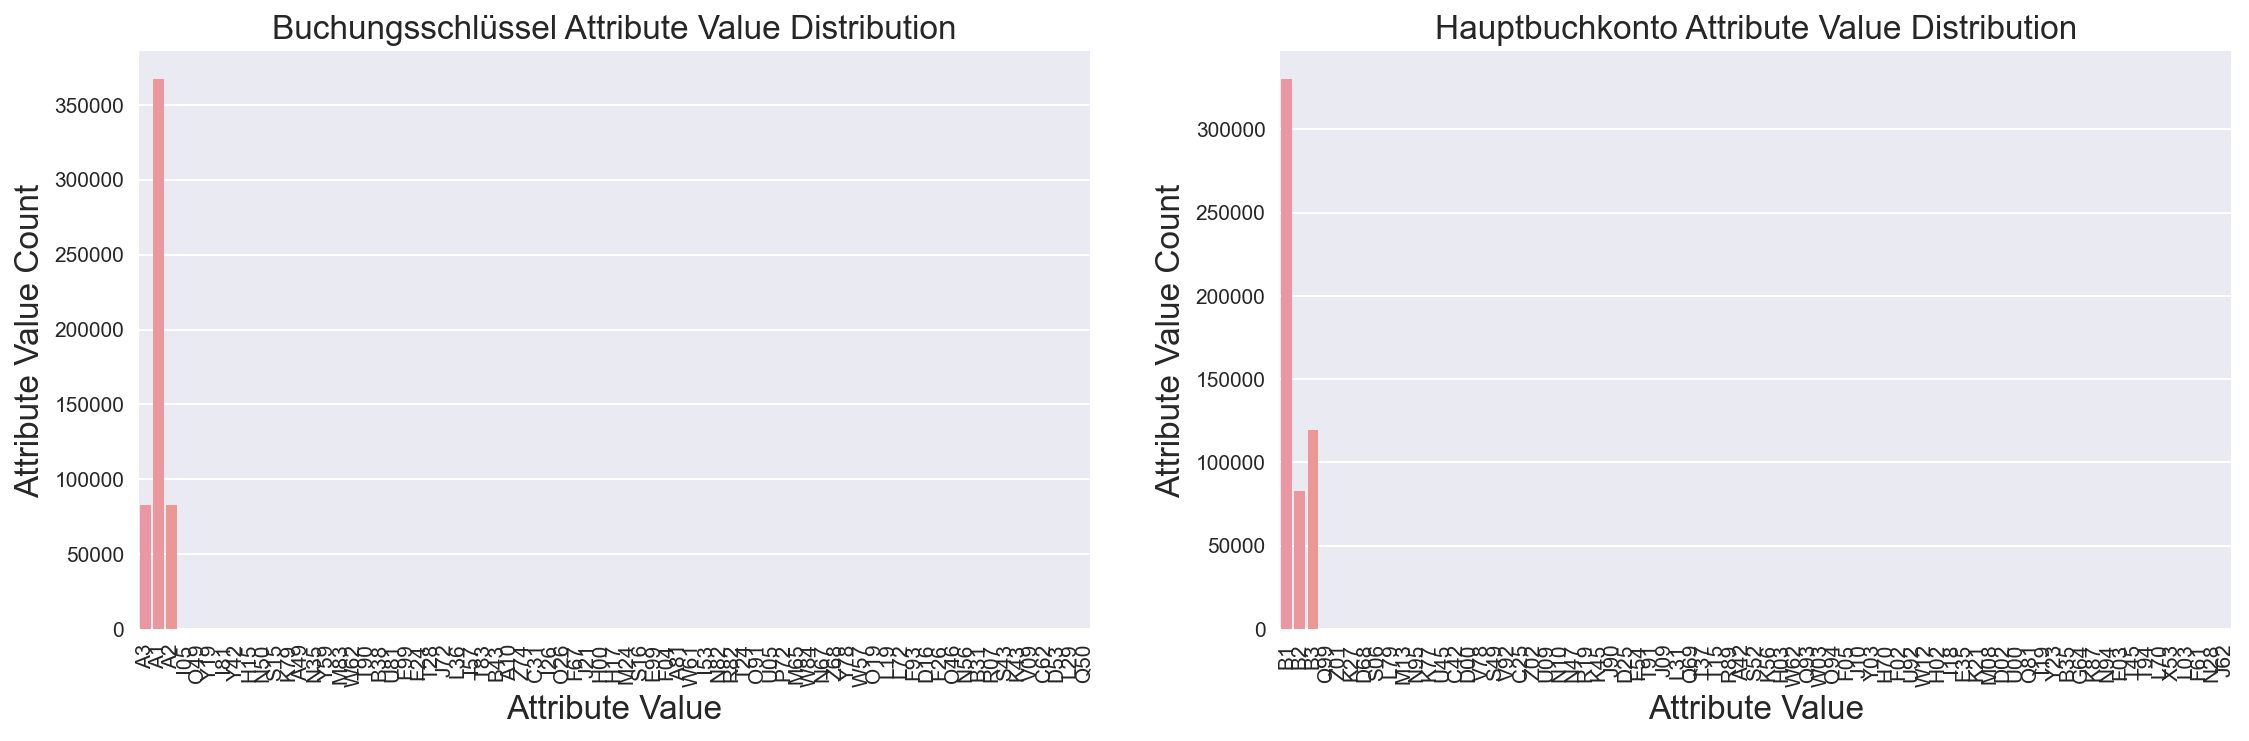

In [18]:
# prepare to plot posting key and general ledger account side by side
fig, ax = plt.subplots(1, 2)
fig.set_figwidth(18)

# plot the distribution of the posting key attribute
plot = sns.countplot(x=ori_dataset['BSCHL'], ax=ax[0])

# set axis labels
plot.set_xticklabels(plot.get_xticklabels(), rotation=90)
plot.set_xlabel('Attribute Value', fontsize=16)
plot.set_ylabel('Attribute Value Count', fontsize=16)

# set plot title
plot.set_title('Buchungsschlüssel Attribute Value Distribution', fontsize=16)

# plot the distribution of the general ledger attribute
plot = sns.countplot(x=ori_dataset['HKONT'], ax=ax[1])

# set axis labels
plot.set_xticklabels(plot.get_xticklabels(), rotation=90)
plot.set_xlabel('Attribute Value', fontsize=16)
plot.set_ylabel('Attribute Value Count', fontsize=16)

# set plot title
plot.set_title('Hauptbuchkonto Attribute Value Distribution', fontsize=16);

Im Allgemeinen sind Neuronale Netze dafür konzipiert numerische Daten zu verarbeiten. Eine Möglichkeit, diese Anforderung zu erfüllen, ist die Anwendung eines Verfahrens, das als sog. **One-Hot Kodierung** bezeichnet wird. Hierdurch kann eine numerische Darstellung kategorischer Attributwerte abgeleitet werden. Bei der **One-Hot Kodierung** wird für jeden kategorischen Attributwert eine zusätzliche binäre Spalte in den Daten erstellt. 

Schauen wir uns hierzu das Beispiel in **Abbildung 2** unten an. Das kategorische Attribut **Receiver** in den Orginaldaten enthält die Namen 'Sally', 'John' und 'Emma'. Wir kodieren das Attribut als 'one-hot' Attribut, indem wir eine zusätzliche binäre Spalte für jeden kategorischen Wert in der Spalte 'Receiver' erstellen. Anschliessend kodieren wir z.B. jede Transaktion, die den Wert 'Sally' in der Spalte 'Receiver' aufweist mit dem Wert 1.0 innerhalb der 'Sally' Spalte der Transaktion. Sollte eine Transaktion einen anderen Wert in der Spalte 'Receiver' aufweisen, kodieren wir die 'Sally' Spalte mit dem Wert 0.0. 

<img align="middle" style="max-width: 500px; height: auto" src="./encoding.png">

**Abbildung 2:** Beispielhafte 'One-Hot' Kodierung der verschiedenen Receiver Attributwerte in spezifische binäre 'One-Hot' Spalten. Dabei resultiert jeder im Datensatz beobachtbare Attributwert in einer eigene Spalte. Der Spaltenwert **1.0** kodiert das Vorkommen des Attributwertes in der entsprechenden Buchung. Der Spaltenwert **0.0** hingegen zeigt, dass der Attributwert nicht innerhalb der entsprechenden Buchung vorkommt.

Anhand dieses Verfahrens können die insgesamt sechs kategorischen Attribute des Datensatzes in numerische Attribute überführt werden. Die `Pandas` Bibliothek stellt hierzu die entsprechende Funktionalität zur Verfügung, welche wir im Nachfolgenden anwenden:

In [19]:
# select categorical attributes to be "one-hot" encoded
categorical_attr_names = ['BUKRS', 'KTOSL', 'PRCTR', 'BSCHL', 'HKONT', 'WAERS']

# encode categorical attributes into a binary one-hot encoded representation 
ori_dataset_cat_processed = pd.get_dummies(ori_dataset[categorical_attr_names])

Nachfolgend überprüfen wie die vorgenommene **One-Hot Kodierung** anhand der 10 ersten Buchungen des Datensatzes:

In [20]:
# inspect encoded sample transactions
ori_dataset_cat_processed.head(10)

,BUKRS_A43,BUKRS_A89,BUKRS_B37,BUKRS_B76,BUKRS_C10,BUKRS_C11,BUKRS_C12,BUKRS_C13,BUKRS_C14,BUKRS_C15,...,WAERS_U72,WAERS_U94,WAERS_V89,WAERS_W25,WAERS_W59,WAERS_X26,WAERS_Y59,WAERS_Z06,WAERS_Z37,WAERS_Z54
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### 2.3 Vorverarbeitung der numerischen Attribute

Anschliessend Analysieren wir nun die Verteilungen der **beiden numerischen Attribute** des Datensatzes. Hierbei handelt es sich um die Attribute (1) *Betrag in Hauswährung* `DMBTR` und (2) *Betrag in Dokumentwährung* `WRBTR` deren jeweilge Verteilungen wir nachfolgend visualisieren: 

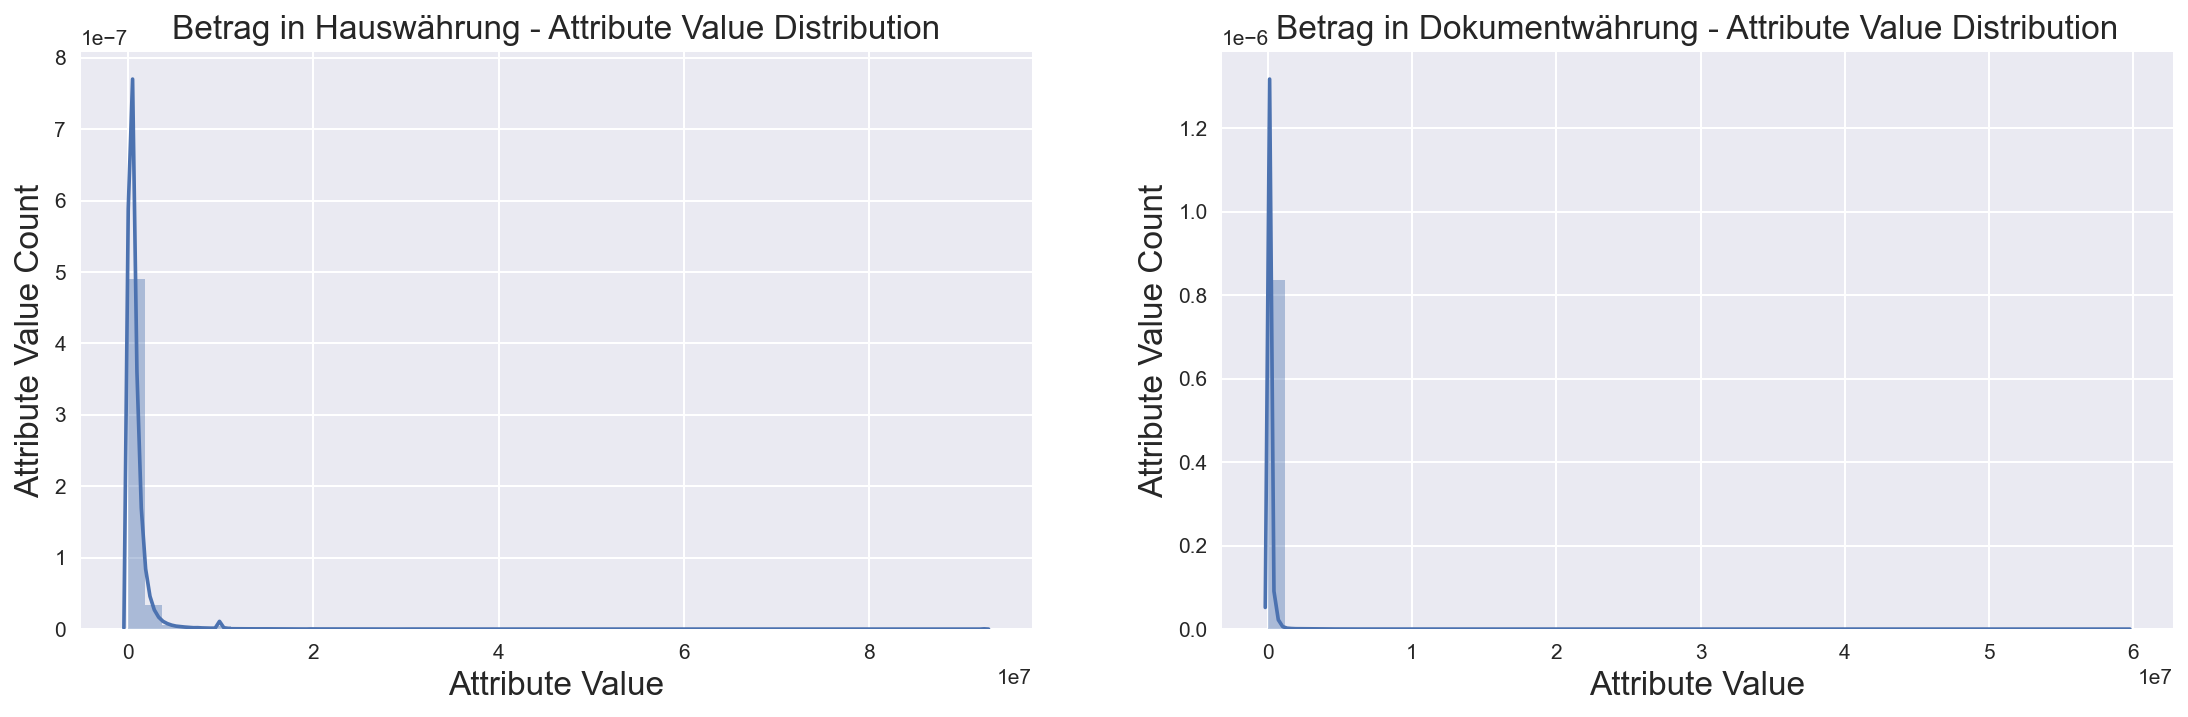

In [21]:
# plot the log-scaled 'DMBTR' as well as the 'WRBTR' attribute value distribution
fig, ax = plt.subplots(1,2)
fig.set_figwidth(18)

# plot distribution of the local amount attribute
plot = sns.distplot(ori_dataset['DMBTR'].tolist(), ax=ax[0])

# set axis labels
plot.set_xlabel('Attribute Value', fontsize=16)
plot.set_ylabel('Attribute Value Count', fontsize=16)

# set plot title
plot.set_title('Betrag in Hauswährung - Attribute Value Distribution', fontsize=16)

# plot distribution of the document amount attribute
plot = sns.distplot(ori_dataset['WRBTR'].tolist(), ax=ax[1])

# set axis labels
plot.set_xlabel('Attribute Value', fontsize=16)
plot.set_ylabel('Attribute Value Count', fontsize=16)

# set plot title
plot.set_title('Betrag in Dokumentwährung - Attribute Value Distribution', fontsize=16);

Die Werte beider Betragsattribute weisen eine jeweils **schiefe** und **steile** Verteilung auf. Wir skalieren deshalb die Werte zunächst logarithmisch. Anschliessend min-max normalisieren wir die Skalierten Werte:

In [22]:
# select the 'DMBTR' and 'WRBTR' attribute
numeric_attr_names = ['DMBTR', 'WRBTR']

# add a small epsilon to eliminate zero values from data for log scaling
numeric_attr = ori_dataset[numeric_attr_names] + 1e-7

# log scale the 'DMBTR' and 'WRBTR' attribute values
numeric_attr = numeric_attr.apply(np.log)

# normalize all numeric attributes to the range [0,1]
ori_dataset_num_processed = (numeric_attr - numeric_attr.min()) / (numeric_attr.max() - numeric_attr.min())

In einem nächsten Schritt visualisieren wir die Verteilungen der skalierten bzw. normierten Werte beider Betragsattribute:

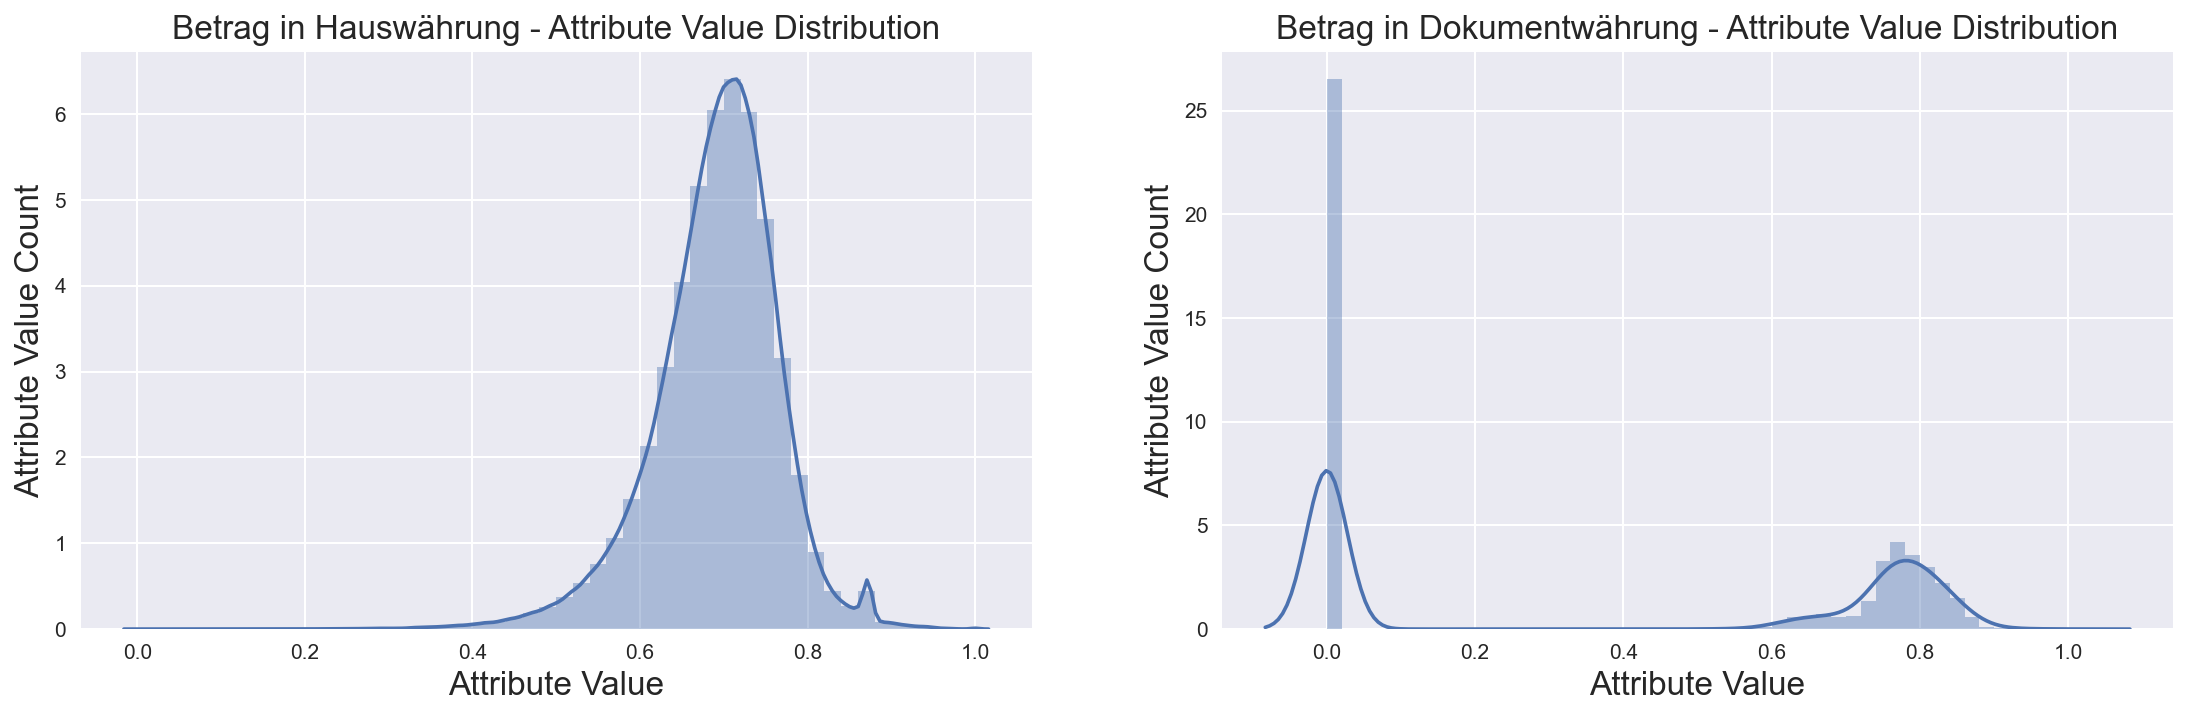

In [23]:
# plot the log-scaled 'DMBTR' as well as the 'WRBTR' attribute value distribution
fig, ax = plt.subplots(1,2)
fig.set_figwidth(18)

# plot distribution of the local amount attribute
plot = sns.distplot(ori_dataset_num_processed['DMBTR'].tolist(), ax=ax[0])

# set axis labels
plot.set_xlabel('Attribute Value', fontsize=16)
plot.set_ylabel('Attribute Value Count', fontsize=16)

# set plot title
plot.set_title('Betrag in Hauswährung - Attribute Value Distribution', fontsize=16)

# plot distribution of the document amount attribute
plot = sns.distplot(ori_dataset_num_processed['WRBTR'].tolist(), ax=ax[1])

# set axis labels
plot.set_xlabel('Attribute Value', fontsize=16)
plot.set_ylabel('Attribute Value Count', fontsize=16)

# set plot title
plot.set_title('Betrag in Dokumentwährung - Attribute Value Distribution', fontsize=16);

### 2.4 Merge Categorical and Numerical Transaction Attributes

Abschliessend fügen wir die beiden vorverarbeiteten numerischen und kategorischen Attribute zu einem **einzigen Datensatz** zusammen. Der zusammengeführte Datensatz bildet die Grundlage für das nachfolgende Training des Deep Autoencoder Neural Networks (AENNs):

In [24]:
# merge categorical and numeric subsets
ori_subset_transformed = pd.concat([ori_dataset_cat_processed, ori_dataset_num_processed], axis = 1)

Werfen wir nun abschliessend noch einen finalen einen Blick auf die Dimensionalität des zusammengefügten Datensatzes:

In [25]:
# inspect final dimensions of pre-processed transactional data
ori_subset_transformed.shape

(533009, 618)

Nach Abschluss der Vorverarbeitungsschritte verfügen wir über einen Datensatz, der aus einer Gesamtzahl von **533,009 Datensätzen** (Zeilen) und **618 Attributen** (Spalten) besteht. Wir behalten die Anzahl der Spalten im Hinterkopf, da sie die Dimensionalität der Eingabe- und Ausgabeschicht unseres AENNs bestimmen wird.

## 3. Adversarial Autoencoder Neural Network Implementierung

In diesem Abschnitt möchten wir uns mit der zugrundeliegenden Idee und dem Aufbau eines **Adversarial Autoencoder Neural Networks (AAENNs)** vertraut zu machen. Hierzu werden wir die einzelne Bausteine und die spezifische Netzwerkstruktur von AAENNs anhand der `PyTorch` Open-Source-Bibliothek implementieren.

### 3.1 Adversarial Autoencoder Neural Network Architektur

Die Architektur des **Adversarial Autoencoder Neural Networks (AAENNs)**, wie in der Abbildung unten dargestellt, erweitert das Konzept klassischer Autoencoder Neural Networks (AENNs), um die Idee sog. **Generative Adversarial Networks (GANs)**. Anhand dieser Erweitung ist es dem AAENN möglich die erlernten Repräsentationen innerhalb des latenten Raum des AAENNs anhand einer beliebigen Prior-Verteilung azuordnen. Das Lernen selbst erfolgt pro Trainingsbatch in zwei Phasen, (1) einer Rekonstruktionsphase und (2) einer Regularisierungsphase.

Innerhalb der **Rekonstruktionsphase** wird der AAENN-Encoder $q_{\theta}(z|x)$ trainiert, um eine aggregierte Posterior-Verteilung $q(z)$ der Journaleinträge $X$ über den latenten Raum $Z$ zu lernen. Dabei entspricht die gelernte Posterior-Verteilung, in Analogie zu AENNs, komprimierten Repräsentatonen der Journalbuchungen. Das  Decoder-Netzwerk $p_{\theta}(\hat{x}|z)$ des AAENNs verwendet die erlernten Repräsentationen $z_i \in Z$ wiederum, um die Journaleinträge so Originalgetreu wie möglich zu rekonstruieren $\hat{X}$. **Zielsetzung der Rekonstruktionsphase ist es den Rekonstruktionsfehler der AAENNs zu minimieren**.

In der **Regularisierungsphase** wird ein adversarial Trainingsverfahren angewandt bei dem das Encoder-Netzwerk $q_{\theta}(z|x)$ zugleich als Generator-Netzwerk fungiert. Zusätzlich erfolgt der Aufsatz eines Diskriminator-Netzwerk $d_{\theta}(z)$ auf den latenten Raum $Z$ des AAENNs. In Analogie zum Training von GANs wird das Diskriminator-Netzwerk des AAENN trainiert, um die Samples einer ausgewählten Prior-Verteilung $p(z) \in Z$, sog. **Fake Verteilung**, von der gelernten Posterior-Verteilung $q(z)$, sog. **True Verteilung**, zu unterscheiden. **Zielsetzung der Regulierungsphase ist es das Diskriminator-Netzwerk des AAENNs maximal zu täuschen**. 

Eine solche Täuschung gelingt dem Generator-Netzwerk wenn sich Fake und True Verteilung $p(z) ≈ q(z)$ nicht mehr signifikant von einander unterscheiden. Das heisst, sich das Diskriminator-Netzwerk nicht sicher ist, ob ein vorliegendes Trainingssample aus der **True Verteilung** $q(z)$ oder der **Fake Verteilung** $p(z)$ stammt.

<img align="middle" style="max-width: 830px; height: auto" src="https://github.com/GitiHubi/deepAD/blob/master/images/autoencoder_2.png?raw=1">

**Abbildung 3:** Schematische Darstellung eines **Adversarial Autoencoder Neural Networks (AAENNs)**, das aus drei nicht-linearen Abbildungen bzw. Feed-Forward-Netzen besteht. Die drei miteinander verknüpften Netze werden als Encoder-Netzwerk $q_\theta: \mathbb{R}^{dx} \mapsto \mathbb{R}^{dz}$, Decoder-Netzwerk $p_\theta: \mathbb{R}^{dz} \mapsto \mathbb{R}^{dx}$, und Discriminator-Netzwerk $d_\phi: \mathbb{R}^{dz} \mapsto \mathbb{R}^{d1}$ bezeichnet.

In [ ]:
#Todo

### 3.1 Encoder Netzwerk Implementierung

In einem nächsten Schritt möchten wir nun das **Encoder Netz $q_{\theta}(z | x)$** in `PyTorch` implementieren. Der Encoder soll aus insgesamt **fünf Schichten von fully-connected Neuronen** bestehen. Darüber hinaus solle der Encoder die nachfolgende Anzahl von Neuronen pro Schicht enthalten: 618-256-64-16-4-2. Die vorhergehende Notation bedeutet, dass die erste Schicht 618 Neuronen umfasst (bestimmt durch die Dimensionalität der Eingabedaten), die zweite Schicht 256 Neuronen und die weiteren Schichten 64, 16, 4 bzw. 2 Neuronen.

Den nachfolgenden drei Elementen der Implementierung des Encoder Netzes möchten wir eine besonderes Augenmerk schenken:

>- `self.encoder_Lx`: definiert die lineare Transformation der jeweiligen Schicht, welche auf die Eingabe angewandt wird: $Wx + b$.
>- `nn.init.xavier_uniform`: initialisiert Gewichtsparameter anhand einer gleichmäßigen Xavier Verteilung.
>- `nn.init.constant`: initialisiert den Bias pro Schicht mit einem konstanten Wert 0.0.
>- `self.encoder_Rx`: definiert die nicht-lineare Transformation der jeweiligen Schicht, welche auf die Eingabe angewandt wird: $\sigma(\cdot)$.

Wir verwenden sog. **Leaky ReLUs**, um saturierende bzw. 'sterbende' Neuronen zu vermeiden und die Trainingskonvergenz zu beschleunigen. Die Anwendung von Leaky ReLUs ermöglicht die Berechnung von Gradienten auch innerhalb des negativen Bereichs einer Aktivierungsfunktion (siehe vorhergehendes Lab 05).

In [33]:
# implementation of the encoder network
class encoder(nn.Module):

    # define class constructor
    def __init__(self):

        # call super class constructor
        super(encoder, self).__init__()

        # specify layer 1 - in 618, out 256
        self.encoder_L1 = nn.Linear(in_features=ori_subset_transformed.shape[1], out_features=256, bias=True) # init linearity
        nn.init.xavier_uniform_(self.encoder_L1.weight) # init weights according to [9]
        nn.init.constant_(self.encoder_L1.bias, 0.0) # constant initialization of the bias
        self.encoder_R1 = nn.LeakyReLU(negative_slope=0.4, inplace=True) # add non-linearity according to [10]

        # specify layer 2 - in 256, out 64
        self.encoder_L2 = nn.Linear(256, 64, bias=True)
        nn.init.xavier_uniform_(self.encoder_L2.weight)
        nn.init.constant_(self.encoder_L2.bias, 0.0)
        self.encoder_R2 = nn.LeakyReLU(negative_slope=0.4, inplace=True)

        # specify layer 3 - in 64, out 16
        self.encoder_L3 = nn.Linear(64, 16, bias=True)
        nn.init.xavier_uniform_(self.encoder_L3.weight)
        nn.init.constant_(self.encoder_L3.bias, 0.0)
        self.encoder_R3 = nn.LeakyReLU(negative_slope=0.4, inplace=True)

        # specify layer 4 - in 16, out 4
        self.encoder_L4 = nn.Linear(16, 4, bias=True)
        nn.init.xavier_uniform_(self.encoder_L4.weight)
        nn.init.constant_(self.encoder_L4.bias, 0.0)
        self.encoder_R4 = torch.nn.LeakyReLU(negative_slope=0.4, inplace=True)

        # specify layer 5 - in 4, out 2
        self.encoder_L5 = nn.Linear(4, 2, bias=True)
        nn.init.xavier_uniform_(self.encoder_L5.weight)
        nn.init.constant_(self.encoder_L5.bias, 0.0)
        self.encoder_R5 = torch.nn.LeakyReLU(negative_slope=0.4, inplace=True)
        
    # define forward pass
    def forward(self, x):

        # run forward pass through the network
        x = self.encoder_R1(self.encoder_L1(x))
        x = self.encoder_R2(self.encoder_L2(x))
        x = self.encoder_R3(self.encoder_L3(x))
        x = self.encoder_R4(self.encoder_L4(x))
        x = self.encoder_R5(self.encoder_L5(x))

        # return result
        return x

In einem nächsten Schritt instanzieren wir ein Modell des Encoder Netzes:

In [34]:
# intstantiate the encoder network model
encoder_train = encoder()

Anschliessend transferieren wir das Encoder Modell auf die `CPU` oder eine ggf. verfügbare `GPU`:

In [35]:
# push model to compute device
encoder_train = encoder_train.to(device)

Sofern verfügbar, prüfen wir ob das Modell erfolgreich auf die `GPU`  übertragen wurde:

In [36]:
!nvidia-smi

/bin/bash: nvidia-smi: command not found


Nun können wir die Modellstruktur visualisieren und die Netzarchitektur nochmals durch das Ausführen der folgenden Zelle überprüfen:

In [37]:
# print the initialized architectures
now = dt.datetime.utcnow().strftime("%Y.%m.%d-%H:%M:%S")
print('[LOG {}] encoder architecture:\n\n{}\n'.format(now, encoder_train))

[LOG 2022.12.08-21:38:03] encoder architecture:

encoder(
  (encoder_L1): Linear(in_features=618, out_features=256, bias=True)
  (encoder_R1): LeakyReLU(negative_slope=0.4, inplace=True)
  (encoder_L2): Linear(in_features=256, out_features=64, bias=True)
  (encoder_R2): LeakyReLU(negative_slope=0.4, inplace=True)
  (encoder_L3): Linear(in_features=64, out_features=16, bias=True)
  (encoder_R3): LeakyReLU(negative_slope=0.4, inplace=True)
  (encoder_L4): Linear(in_features=16, out_features=4, bias=True)
  (encoder_R4): LeakyReLU(negative_slope=0.4, inplace=True)
  (encoder_L5): Linear(in_features=4, out_features=2, bias=True)
  (encoder_R5): LeakyReLU(negative_slope=0.4, inplace=True)
)



### 3.2 Decoder Netzwerk Implementierung

In einem nächsten Schritt vervollständigen wir nun die Autoencoder Architektur des AAENNs durch die Implementierung des entsprechenden **Decoder Netzes $p_{\theta}(\hat{x}|z)$**. Der Decoder soll ebenfall aus insgesamt **fünf Schichten** von fully-connected Neuronen bestehen. Zudem soll der Decoder die Architektur des Encoders  **symmetrisch spiegeln**. Wir invertieren hierzu die Ausgestaltung der Schichten des Encoders schichtweise, gemäss der folgenden Struktur 2-4-16-64-256, im Rahmen der Implementierung des Decoders:

In [41]:
# implementation of the decoder network
class decoder(nn.Module):

    # define class constructor
    def __init__(self):

        # call super class constructor
        super(decoder, self).__init__()

        # specify layer 1 - in 2, out 4
        self.decoder_L1 = nn.Linear(in_features=2, out_features=4, bias=True) # init linearity
        nn.init.xavier_uniform_(self.decoder_L1.weight) # init weights according to [9]
        nn.init.constant_(self.decoder_L1.bias, 0.0) # constant initialization of the bias
        self.decoder_R1 = nn.LeakyReLU(negative_slope=0.4, inplace=True) # add non-linearity according to [10]

        # specify layer 2 - in 4, out 16
        self.decoder_L2 = nn.Linear(4, 16, bias=True)
        nn.init.xavier_uniform_(self.decoder_L2.weight)
        nn.init.constant_(self.decoder_L2.bias, 0.0)
        self.decoder_R2 = nn.LeakyReLU(negative_slope=0.4, inplace=True)

        # specify layer 3 - in 16, out 64
        self.decoder_L3 = nn.Linear(16, 64, bias=True)
        nn.init.xavier_uniform_(self.decoder_L3.weight)
        nn.init.constant_(self.decoder_L3.bias, 0.0)
        self.decoder_R3 = nn.LeakyReLU(negative_slope=0.4, inplace=True)

        # specify layer 4 - in 64, out 256
        self.decoder_L4 = nn.Linear(64, 256, bias=True)
        nn.init.xavier_uniform_(self.decoder_L4.weight)
        nn.init.constant_(self.decoder_L4.bias, 0.0)
        self.decoder_R4 = nn.LeakyReLU(negative_slope=0.4, inplace=True)
        
        # specify layer 5 - in 256, out 618
        self.decoder_L5 = nn.Linear(256, ori_subset_transformed.shape[1], bias=True)
        nn.init.xavier_uniform_(self.decoder_L5.weight)
        nn.init.constant_(self.decoder_L5.bias, 0.0)
        self.decoder_S5 = torch.nn.Sigmoid()
        
    # define forward pass
    def forward(self, x):

        # run forward pass through the network
        x = self.decoder_R1(self.decoder_L1(x))
        x = self.decoder_R2(self.decoder_L2(x))
        x = self.decoder_R3(self.decoder_L3(x))
        x = self.decoder_R4(self.decoder_L4(x))
        x = self.decoder_S5(self.decoder_L5(x))

        # return result
        return x

Wir instanzieren nun auch das Decoder Modell für das `CPU` bzw. `GPU`Training und überzeugen uns davon, dass das Modell erfolgreich initialisiert wurde. Hierzu visualisieren wir wieder die Netzarchitektur durch das Ausführen der nachfolgenden Zelle:

In [42]:
# intstantiate the decoder network model
decoder_train = decoder()

# push model to compute device
decoder_train = decoder_train.to(device)
    
# print the initialized architectures
now = dt.datetime.utcnow().strftime("%Y.%m.%d-%H:%M:%S")
print('[LOG {}] decoder architecture:\n\n{}\n'.format(now, decoder_train))

[LOG 2022.12.08-21:57:52] decoder architecture:

decoder(
  (decoder_L1): Linear(in_features=2, out_features=4, bias=True)
  (decoder_R1): LeakyReLU(negative_slope=0.4, inplace=True)
  (decoder_L2): Linear(in_features=4, out_features=16, bias=True)
  (decoder_R2): LeakyReLU(negative_slope=0.4, inplace=True)
  (decoder_L3): Linear(in_features=16, out_features=64, bias=True)
  (decoder_R3): LeakyReLU(negative_slope=0.4, inplace=True)
  (decoder_L4): Linear(in_features=64, out_features=256, bias=True)
  (decoder_R4): LeakyReLU(negative_slope=0.4, inplace=True)
  (decoder_L5): Linear(in_features=256, out_features=618, bias=True)
  (decoder_S5): Sigmoid()
)



### 3.2 Discriminator Netzwerk Implementierung

In einem finalen Schritt erweitern wir nun die Autoencoder Architektur des AAENNs um das dritte notwendige Netzwerk. Dies geschieht durch die Implementierung des **Discriminator Netzes $d_{\theta}(z)$**. Der Discriminator soll aus insgesamt **vier Schichten** von fully-connected Neuronen bestehen. Hierbei ist zu beachten, dass die **Eingabeschicht des Discriminators** die gleiche Dimensionalität wie die **Ausgabeschicht des Encoders** aufweist. Die vier Schichten des Discriminators umfassen die nachfolgende Anzahl Neuronen pro Schicht 256-16-4-2.

In [43]:
# implementation of the discriminator network
class discriminator(nn.Module):

    # define class constructor
    def __init__(self):

        # call super class constructor
        super(discriminator, self).__init__()

        # specify first layer - in 2, out 256
        self.discriminator_L1 = nn.Linear(2, 256, bias=True) # init linearity
        nn.init.xavier_uniform_(self.discriminator_L1.weight) # init weights according to [9]
        nn.init.constant_(self.discriminator_L1.bias, 0.0) # constant initialization of the bias
        self.discriminator_R1 = nn.LeakyReLU(negative_slope=0.4, inplace=True) # add non-linearity according to [10]

        # specify second layer - in 256, out 16
        self.discriminator_L2 = nn.Linear(256, 16, bias=True)
        nn.init.xavier_uniform_(self.discriminator_L2.weight)
        nn.init.constant_(self.discriminator_L2.bias, 0.0)
        self.discriminator_R2 = nn.LeakyReLU(negative_slope=0.4, inplace=True)

        # specify third layer - in 16, out 4
        self.discriminator_L3 = nn.Linear(16, 4, bias=True)
        nn.init.xavier_uniform_(self.discriminator_L3.weight)
        nn.init.constant_(self.discriminator_L3.bias, 0.0)
        self.discriminator_R3 = nn.LeakyReLU(negative_slope=0.4, inplace=True)
        
        # specify fourth layer - in 4, out 2
        self.discriminator_L4 = nn.Linear(4, 2, bias=True)
        nn.init.xavier_uniform_(self.discriminator_L4.weight)
        nn.init.constant_(self.discriminator_L4.bias, 0.0)
        self.discriminator_S4 = torch.nn.Sigmoid()

    # define forward pass
    def forward(self, x):

        # run forward pass through the network
        x = self.discriminator_R1(self.discriminator_L1(x))
        x = self.discriminator_R2(self.discriminator_L2(x))
        x = self.discriminator_R3(self.discriminator_L3(x))
        x = self.discriminator_S4(self.discriminator_L4(x))

        # return result
        return x

Wir instanzieren nun auch das Discriminator Modell für das `CPU` bzw. `GPU`Training und überzeugen uns davon, dass das Modell erfolgreich initialisiert wurde. Hierzu visualisieren wir wieder die Netzarchitektur durch das Ausführen der nachfolgenden Zelle:

In [44]:
# intstantiate the discriminator network model
discriminator_train = discriminator()

# push model to compute device
discriminator_train = discriminator_train.to(device)
    
# print the initialized architectures
now = dt.datetime.utcnow().strftime("%Y.%m.%d-%H:%M:%S")
print('[LOG {}] discriminator architecture:\n\n{}\n'.format(now, discriminator_train))

[LOG 2022.12.08-22:11:03] discriminator architecture:

discriminator(
  (discriminator_L1): Linear(in_features=2, out_features=256, bias=True)
  (discriminator_R1): LeakyReLU(negative_slope=0.4, inplace=True)
  (discriminator_L2): Linear(in_features=256, out_features=16, bias=True)
  (discriminator_R2): LeakyReLU(negative_slope=0.4, inplace=True)
  (discriminator_L3): Linear(in_features=16, out_features=4, bias=True)
  (discriminator_R3): LeakyReLU(negative_slope=0.4, inplace=True)
  (discriminator_L4): Linear(in_features=4, out_features=2, bias=True)
  (discriminator_S4): Sigmoid()
)



Abschliessend werfen wir noch einen Blick auf die Anzahl der Modellparameter, die wir im Folgenden beabsichtigen zu trainieren:

In [46]:
# init the number of encoder model parameters
encoder_num_params = 0

# iterate over the distinct encoder parameters
for param in encoder_train.parameters():

    # collect number of parameters
    encoder_num_params += param.numel()

# init the number of decoder model parameters
decoder_num_params = 0
    
# iterate over the distinct decoder parameters
for param in decoder_train.parameters():

    # collect number of parameters
    decoder_num_params += param.numel()

# init the number of discriminator model parameters
discriminator_num_params = 0
    
# iterate over the distinct discriminator parameters
for param in discriminator_train.parameters():

    # collect number of parameters
    discriminator_num_params += param.numel()
    
# print the number of model paramters
now = dt.datetime.utcnow().strftime("%Y.%m.%d-%H:%M:%S")
print('[LOG {}] number of to be trained AAENN model parameters: {}.'.format(now, encoder_num_params + decoder_num_params + discriminator_num_params))

[LOG 2022.12.08-22:12:57] number of to be trained AAENN model parameters: 357634.


Ok, unser AAENN Modell umfasst eine beachtliche Gesamtzahl von **357.634 zu trainierenden Modellparametern**.

### 3.4 Adversarial Autoencoder Neural Network Training

Nachdem wir nun das AAENN implementiert haben, möchten wir in einem nächsten Schritt das Netz trainieren. Bevor wir jedoch mit dem Training beginnen, ist es notwendig geeignete Fehlerfunktionen zu definieren. Zur Erinnerung: Wir wollen das Modell jeweils in zwei Trainingsphasen trainieren, nämlich (1) einer **Rekonstruktionsphase** und (2) einer **Regularisierungsphase**. Im Folgenden werden wir die Trainingsparameter für jede der Beiden Trainingsphasen festlegen.

#### 3.4.1 Parametrisierung der Rekonstruktionsphase

In der Rekonstruktionsphase wird der Encoder $q_{\theta}(z|x)$ trainiert, um eine aggregierte Posterior-Verteilung $q(z)$ der Journalbuchungen $X$ innerhalb des latenten Raums $Z$ zu lernen. Dabei entspricht die gelernte Posterior-Verteilung komprimierten Repräsentationen der Merkmale der Journalbuchungen. In Analogie zu klassischen Autoencoder Neuronalen Netzen nutzt der Decoder $p_{\theta}(\hat{x}|z)$ die gelernten latenten Repräsentationen $z_{i} \in Z$, um die Journaleinträge so getreu wie möglich zu rekonstruieren $\hat{X}$ und den Rekonstruktionsfehler der AAENNs zu minimieren.

Um dieses Lernziel zu erreichen, verwenden wir im folgenden unterschiedliche Rekonstruktionsfehler entsprechend der Art der zu rekonstruierenden Buchungsmerkmale. Für kategorische Merkmalsausprägungen $x^{i}_{cat}$, z.B. verwenden wir den **Binary-Cross-Entropy (BCE)** Rekonstruktionsfehler. Für numerische Merkmalsausprägungen $x^{i}_{con}$, z.B. , verwenden wir den **Mean-Squared-Error (MSE)** Rekonstruktionsfehler. Abschliessend werden pro zu rekonstruierender Journalbuchung $x^{i}$ beide Fehler additiv, wie nachfolgend, miteinander verknüpft:

<center> $\mathcal{L}_{\theta}^{REC}(x;\hat{x}) = \gamma \hspace{1mm} \mathcal{L}^{BCE}_{\theta}(x_{cat};\hat{x}_{cat}) + (1 - \gamma) \hspace{1mm} \mathcal{L}^{MSE}_{\theta}(x_{con};\hat{x}_{con})$ </center>

wobei $x^{i}$, $i=1,...,n$ die Menge an Buchungen bezeichnet, $\hat{x}^{i}$ die jeweiligen Rekonstruktionen und $j=1,...,k$ die verschiedenen Buchungsattribute indexiert. Nachfolgend instanzieren wir die entsprechende BCE Fehlerfunktion $\mathcal{L}^{BCE}$ und MSE Fehlerfunktion $\mathcal{L}^{MSE}$ der `PyTorch` Bibliothek:

In [48]:
# define the bce optimization criterion / loss function
reconstruction_loss_categorical = nn.BCELoss(reduction='mean')

# define the mse optimization criterion / loss function
reconstruction_loss_numerical = nn.MSELoss(reduction='mean')

Anschliessend transferieren wir die Berechnung der beiden Fehlerfunktionen auf die `CPU` oder eine ggf. verfügbare `GPU`:

In [49]:
# push the optimization criterion / loss function to compute device 
reconstruction_loss_categorical = reconstruction_loss_categorical.to(device)
reconstruction_loss_numerical = reconstruction_loss_numerical.to(device)

Auf der Grundlage der Fehlerhöhe eines Mini-Batches an Buchungen berechnet die `PyTorch` Bibliothek automatisiert die Gradienten. Anschliessend werden AAENN-Parameter $\theta$ auf Grundlage der ermittelten Gradienten optimiert. Hierzu ist es notwendig das gewünschte Optimierungsverfahren in **PyTorch** zu definieren. In der nachfolgenden Notebook Zelle verwenden wir das sog. **Adam Optimierungsverfahren** für die Optimierung der Modellparameter $\theta$. Darüber hinaus definieren eine Lernrate $l = 0.001$ sowohl für die Optimierung des Encoder als auch das Decoder Netzwerk:

In [50]:
# set encoder and decoder learning rate
learning_rate_encoder = 1e-3
learning_rate_decoder = 1e-3

# define encoder and decoder optimization strategy
encoder_optimizer = optim.Adam(encoder_train.parameters(), lr=learning_rate_encoder)
decoder_optimizer = optim.Adam(decoder_train.parameters(), lr=learning_rate_decoder)

#### 3.4.2 Parametrisierung der Regulierungsphase

In der Regularisierungsphase wird ein adversarial Trainingsverfahren angewandt, in welchem der Encoder $q_{\theta}(z|x)$ des AAENN als Generator fungiert. Zusätzlich wird ein Diskriminator-Netzwerk $d_{\phi}(z)$ auf den gelernten latenten Raum $Z$ aufgesetzt. In Analogie zum Training von Generative Adversarial Networks (GANs) wird der Discriminator des AAENN trainiert. Die Zielsetzung des Trainining ist es hierbei Samples einer **Fake Prior-Verteilung $p(z)$** in $z_{i} \in Z$ von der erlernten **True Posterior-Verteilung $q(z)$** zu unterscheiden. Prallel hierzu wird der Encoder mit der Zielsetzung trainiert, eine **True Posterior-Verteilung** der Art zu lernen, dass $p(z) \approx q(z)$. Hierdurch wird dem Diskriminator maximal verwirrt vorgaukelt, dass die aus $q(z)$ gezogenen Samples aus $p(z)$ stammen und umgekehrt. Eine hierfür geeignete Fehlerfunktion findet sich im sog. **Binary-Cross-Entropy (BCE)** Klassifikationsfehler, der formal wie nachfolgend definiert ist:

<center> $\mathcal{L^{Dis}_{\phi}}(y^{i};\hat{y}^{i}) = \frac{1}{n}\sum_{i=1}^{n} y^{i} ln(\hat{y}^{i}) + (1-y^{i}) ln(1-\hat{y}^{i})$, </center>

wobei $y^{i}$ das tatsächliche Klassenlabel der Verteilung (Fake Prior oder True Posterior Verteilung) bezeichnet und $\hat{y}^{i}$ das durch den Discriminator vorhergesagte Klassenlabel.  Nachfolgend instanzieren wir die entsprechende BCE Fehlerfunktion der `PyTorch` Bibliothek:

In [53]:
# define the bce optimization criterion / loss function
discriminator_loss = nn.BCELoss()

Anschliessend transferieren wir die Berechnung der Fehlerfunktion auf die `CPU` oder eine ggf. verfügbare `GPU`:

In [54]:
# push the optimization criterion / loss function to compute device 
discriminator_loss = discriminator_loss.to(device)

Auf der Grundlage der BCE Fehlerhöhe eines Mini-Batches von latenten Samples berechnet die `PyTorch` Bibliothek automatisiert die Gradienten. Anschliessend werden die Parameter des Discriminators $\phi$ auf Grundlage der ermittelten Gradienten optimiert. In der nachfolgenden Notebook Zelle verwenden wir das sog. **Adam Optimierungsverfahren** für die Optimierung der $\phi$ Parameter. Darüber hinaus definieren eine Lernrate $l = 0.00001$:

In [55]:
# set generator and discriminator learning rate
learning_rate_discriminator = 1e-5

# set generator and discriminator optimization strategy
discriminator_optimizer = optim.Adam(discriminator_train.parameters(), lr=learning_rate_discriminator)

Nachdem wir die drei Netze des aAENN-Modells erfolgreich implementiert und instanziiert haben. Nehmen wir uns Zeit, die Definition der Modelle **(1) Encoder**, **(2) Decoder** und **(3) Discriminator** sowie die Fehlerfunktionen nochmals zu überprüfen und etwaige Fragen zu besprechen.

### 3.5 Gaussian Mixture Prior Implementierung

In einem nächsten Schritt erstellen wir eine Prior-Verteilung, welches es uns ermöglicht im Laufe des Trainingsprozesses zu samplen. Um die durch den AAENN gelernten Repräsentationen der Journalbuchungen im latenten Raum $Z$ zu partitionieren samplen wir aus einer **Prior-Verteilung $p(z)$, die aus einem Mixture von $\tau$ multivariaten isotropen Gauss-Verteilungen $\mathcal{N}(\mu,\mathcal{I})$ besteht**. Um die Ergebnisse im Nachfolgenden visualisieren zu können samplen wir aus einer zwei dimensionalen Prior-Verteilung $\mu \in \mathcal{R}^{2}$ ist. Nachfolgend möchten wir die die Journalbuchungen in insgesamt fünf generative Prozesse partitionieren. Hierzu erstellen wir eine Prior-Verteilung $p(z)$, die insgesamt $\tau=5$ isotropen Gauss-Verteilungen umfasst. 

Hierzu definieren wir zunächst die nachfolgenden vier Parameter: Anzahl Gauss-Verteilungen $\tau$, Radius der einzelnen Verteilungen $r$, Standardabweichungen der Verteilungen $\sigma$ und die Dimension der Verteilungen $\mathcal{R}^{d}$:

In [ ]:
# define the number of gaussians
tau = 5 

# define radius of each gaussian
radius = 0.8

# define the sigma of each gaussian
sigma = 0.01

# define the dimensionality of each gaussian
dim = 2

In einem nächsten Schritt, erstellen wir die gewünschte **Prior-Verteilung $p(z)$**. Hierzu samplen wir jeweils 1,000 zufällige samples von jeder Gauss-Verteilung der gewünschten Prior-Verteilung:

In [56]:
# determine x and y coordinates of the target mixture of gaussians
x_centroid = (radius * np.sin(np.linspace(0, 2 * np.pi, tau, endpoint=False)) + 1) / 2
y_centroid = (radius * np.cos(np.linspace(0, 2 * np.pi, tau, endpoint=False)) + 1) / 2

# determine each gaussians mean (centroid) and standard deviation
mu_gauss = np.vstack([x_centroid, y_centroid]).T

# determine the number of samples to be created per gaussian
samples_per_gaussian = 100000

# iterate over the number of distinct gaussians
for i, mu in enumerate(mu_gauss):

    # case: first gaussian distribution
    if i == 0:

        # randomly sample from gaussian distribution 
        z_continous_samples_all = np.random.normal(mu, sigma, size=(samples_per_gaussian, dim))

    # case: non-first gaussian distribution
    else:

        # randomly sample from gaussian distribution
        z_continous_samples = np.random.normal(mu, sigma, size=(samples_per_gaussian, dim))

        # collect and stack new samples
        z_continous_samples_all = np.vstack([z_continous_samples_all, z_continous_samples])

Abschliessend möchten wir nun die gewünschte Prior-Verteilung $p(z)$ visuell prüfen:

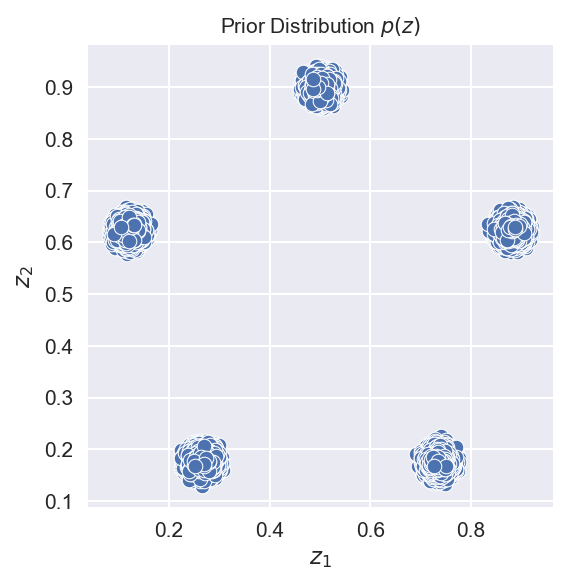

In [61]:
# init the plot
fig = plt.figure(figsize=(4, 4))
ax = fig.add_subplot(111)

# plot prior distribution scatter plot
ax.scatter(z_continous_samples_all[:, 0], z_continous_samples_all[:, 1], c='C0', marker="o", edgecolors='w', linewidth=0.5) 

# add axis labels
ax.set_xlabel('$z_1$')
ax.set_ylabel('$z_2$')

# add plot title
ax.set_title('Prior Distribution $p(z)$', size=10);

Ok, die Samples der gewünschten Prior-Verteilung $p(z)$ entsprechen der erwarteten Verteilung. Anschliessend werden wir die Verteilung nun im Rahmen des AAENN Trainings verwenden.

## 4. Adversarial Autoencoder Neural Network Network

In diesem Abschnitt möchten wir nun ein AAENN-Modell anhand der kodierten Transaktionsdaten trainieren. Darüber hinaus werfen wir einen detaillierten Blick auf die einzelnen Trainingshyperparameter und Trainingsschritte sowie den Trainingsfortschritt im Zeitverlauf. 

### 4.1 Definition der Hyperparameter

Beginnen wir nun damit, ein AAENN Modell für **100 Trainingsepochen** und **128 Buchungen pro Mini-Batch** zu trainieren. Diese Konfiguration der Hyperparameter bedeutet, dass der Datensatz dem AENN ingesamt hundertmal in Mini-Batches von 128 jeweils Buchungen zugeführt wird. Diese Hyperparameter Konfiguration hat zu Folge, dass pro Trainingsepoche **4,165 Updates** (533,009 Buchungen modulo 128 Buchungen pro Mini-Batch) der AAENN Modellparameter erfolgen. 

In [62]:
# specify training parameters
num_epochs = 10 # number of training epochs
mini_batch_size = 128 # size of the mini-batches

Während der Trainingsphase sollen dem AENN Modell kontinuierlich Mini-Batches der gesamten Population von Buchungen zugeführt werden. Hierzu verwenden wir die `DataLoader` Funktionalität der `PyTorch` Bibliothek. Dabei handelt es sich im sog. Iteratoren, welche die Buchungen kontinuierlich in Form von Mini-Batches zur Verfügung stellen. Durch die Aktivierung des Parameters `shuffle=True` werden die Daten in jeder Epoche neu gemischt, bevor sie dem Netz zugeführt werden. In der nachfolgenden Zelle instanzieren wir einen PyTorch Dataloader der Buchungsdaten:

In [63]:
# convert pre-processed transactional data to PyTorch tensor
torch_dataset = torch.from_numpy(ori_subset_transformed.values).float()

# push pre-processed transactional data to compute device
torch_dataset = torch_dataset.to(device)

# init training dataloader
train_dataloader = dataloader.DataLoader(torch_dataset, batch_size=mini_batch_size, shuffle=True)

### 4.2 Training des Models

Finally, we start training the model. The training procedure of each mini-batch is performed in two phases, namely a (1) reconstruction phase and (2) regularization phase. The distinct training steps conducted during the reconstruction phase are the following:

>1. do a journal entry batch forward pass through the encoder-decoder networks,
>2. compute the combined reconstruction loss $\mathcal{L}_{\theta}^{REC}(x^{i};\hat{x}^{i})$, 
>3. do a backward pass through the encoder-decoder part, and,
>4. update the parameters of the encoder $q_\theta(\cdot)$ and decoder $p_\theta(\cdot)$ networks.

The distinct training steps conducted during the regularization phase are the following (discriminator training):

>1. do a journal entry batch forward pass through the generator network to obtain representation $z^{i}_{fake} \sim q_\theta(\cdot)$,
>2. sample representation from the imposed mixture of Gaussians prior distribution $z^{i}_{real} \sim p(\cdot)$,
>3. compute the discrimination loss $\mathcal{L}_{\theta}^{DIS}(z^{i}_{fake}; z^{i}_{real})$, and,
>4. update the parameters of the discriminator $d_\phi(\cdot)$ network.

The distinct training steps conducted during the regularization phase are the following (generator training):

>1. do a journal entry batch forward pass through the generator network to obtain representation $z^{i}_{fake} \sim q_\theta(\cdot)$,
>2. compute the generation loss $\mathcal{L}_{\theta}^{GEN}(z^{i}_{fake})$, and,
>3. update the parameters of the generator $q_\theta(\cdot)$ network.

To ensure learning while training our AENN model we will monitor whether the distinct losses decrease with progressing training. Therefore, we obtain and evaluate the reconstruction loss $\mathcal{L}_{\theta}^{REC}$, the discrimination loss $\mathcal{L}_{\theta}^{DIS}$, as well as, the generation loss $\mathcal{L}_{\theta}^{GEN}$ of the entire dataset after each training epoch. Based on this evaluation we conclude on the training progress and whether the loss is converging (indicating that the learned model might not improve any further).

In addition, after each training epoch we want to save a checkpoint for both the actual `encoder`, `decoder` and `discriminator` model. The saved model checkpoints contain a snapshot of the trained model parameter values upon completion of a training epoch. In general, it is good practice, to save checkpoints at regular intervals during training. In case your system crashes during training you are able continue from the last checkpoint rather than start over from scratch.

>- `torch.save()`: saves a checkpoint of the actual encoder and decoder model parameter values to disc.

Initialize the per epoch collected model losses:

In [ ]:
# init collection of training losses
epoch_reconstruction_losses = []
epoch_discriminator_losses = []
epoch_generator_losses = []

Define the verbose step size of the adversarial autoencoder training process:

In [ ]:
mini_batch_verbose_step = 1000

Let's now start the adversarial autoencoder network training:

In [ ]:
# initialize training adversarial autoencoder model
for epoch in range(num_epochs):

    # init mini batch counter
    mini_batch_count = 0
    
    # init epoch training losses
    batch_reconstruction_losses = 0.0
    batch_discriminator_losses = 0.0
    batch_generator_losses = 0.0

    # determine if GPU training is enabled
    if (torch.backends.cudnn.version() != None) and (USE_CUDA == True):

        # set all networks / models in GPU mode
        encoder_train.cuda()
        decoder_train.cuda()
        discriminator_train.cuda()

    # set networks in training mode (apply dropout when needed)
    encoder_train.train()
    decoder_train.train()
    discriminator_train.train()
    
    # start timer
    start_time = datetime.now()

    # iterate over epoch mini batches
    for mini_batch_data in dataloader:

        # increase mini batch counter
        mini_batch_count += 1

        # determine if GPU training is enabled
        if (torch.backends.cudnn.version() != None) and (USE_CUDA == True):
          
            # convert mini batch to torch variable
            mini_batch_torch = torch.cuda.FloatTensor(mini_batch_data)

        else:
          
             # convert mini batch to torch variable
             mini_batch_torch = torch.FloatTensor(mini_batch_data)
        
        # reset the networks gradients
        encoder_train.zero_grad()
        decoder_train.zero_grad()
        discriminator_train.zero_grad()

        # =================== reconstruction phase =====================
        
        # run autoencoder encoding - decoding
        z_sample = encoder_train(mini_batch_torch)
        mini_batch_reconstruction = decoder_train(z_sample)

        # split input date to numerical and categorical part
        batch_cat = mini_batch_torch[:, :ori_dataset_categ_transformed.shape[1]]
        batch_num = mini_batch_torch[:, ori_dataset_categ_transformed.shape[1]:]
        
        # split reconstruction to numerical and categorical part
        rec_batch_cat = mini_batch_reconstruction[:, :ori_dataset_categ_transformed.shape[1]]
        rec_batch_num = mini_batch_reconstruction[:, ori_dataset_categ_transformed.shape[1]:]

        # backward pass + gradients update
        rec_error_cat = reconstruction_criterion_categorical(input=rec_batch_cat, target=batch_cat)  # one-hot attr error
        rec_error_num = reconstruction_criterion_numeric(input=rec_batch_num, target=batch_num)  # numeric attr error

        # combine both reconstruction errors
        reconstruction_loss = rec_error_cat + rec_error_num
        
        # run backward pass - determine gradients
        reconstruction_loss.backward()
        
        # collect batch reconstruction loss
        batch_reconstruction_losses += reconstruction_loss.item()
        
        # update network parameter - decoder and encoder
        decoder_optimizer.step()
        encoder_optimizer.step()

        # =================== regularization phase =====================
        # =================== discriminator training ===================

        # set discriminator in evaluation mode
        discriminator_train.eval()

        # generate target latent space data
        z_target_batch = z_continous_samples_all[random.sample(range(0, z_continous_samples_all.shape[0]), mini_batch_size),:]

        # convert to torch tensor
        z_target_batch = torch.FloatTensor(z_target_batch)

        if (torch.backends.cudnn.version() != None) and (USE_CUDA == True):
            z_target_batch = z_target_batch.cuda()

        # determine mini batch sample generated by the encoder -> fake gaussian sample
        z_fake_gauss = encoder_train(mini_batch_torch)

        # determine discriminator classification of both samples
        d_real_gauss = discriminator_train(z_target_batch) # real sampled gaussian 
        d_fake_gauss = discriminator_train(z_fake_gauss) # fake created gaussian

        # determine discriminator classification target variables
        d_real_gauss_target = torch.FloatTensor(torch.ones(d_real_gauss.shape)) # real -> 1
        d_fake_gauss_target = torch.FloatTensor(torch.zeros(d_fake_gauss.shape)) # fake -> 0

        # determine if GPU training is enabled
        if (torch.backends.cudnn.version() != None) and (USE_CUDA == True):

            # push tensors to CUDA
            d_real_gauss_target = d_real_gauss_target.cuda()
            d_fake_gauss_target = d_fake_gauss_target.cuda()

        # determine individual discrimination losses
        discriminator_loss_real = discriminator_criterion(target=d_real_gauss_target, input=d_real_gauss) # real loss
        discriminator_loss_fake = discriminator_criterion(target=d_fake_gauss_target, input=d_fake_gauss) # fake loss
        
        # add real loss and fake loss
        discriminator_loss = discriminator_loss_fake + discriminator_loss_real

        # run backward through the discriminator network
        discriminator_loss.backward()
        
        # collect discriminator loss
        batch_discriminator_losses += discriminator_loss.item()

        # update network the discriminator network parameters
        discriminator_optimizer.step()

        # reset the networks gradients
        encoder_train.zero_grad()
        decoder_train.zero_grad()
        discriminator_train.zero_grad()

        # =================== regularization phase =====================
        # =================== generator training =======================

        # set encoder / generator in training mode
        encoder_train.train()
        
        # reset the encoder / generator networks gradients
        encoder_train.zero_grad()

        # determine fake gaussian sample generated by the encoder / generator
        z_fake_gauss = encoder_train(mini_batch_torch)

        # determine discriminator classification of fake gaussian sample
        d_fake_gauss = discriminator_train(z_fake_gauss)

        # determine discriminator classification target variables
        d_fake_gauss_target = torch.FloatTensor(torch.ones(d_fake_gauss.shape)) # fake -> 1

        # determine if GPU training is enabled
        if (torch.backends.cudnn.version() != None) and (USE_CUDA == True):

            # push tensors to CUDA
            d_fake_gauss_target = d_fake_gauss_target.cuda()

        # determine discrimination loss of fake gaussian sample
        generator_loss = discriminator_criterion(target=d_fake_gauss_target, input=d_fake_gauss)
        
        # collect generator loss
        batch_generator_losses += generator_loss.item()

        # run backward pass - determine gradients
        generator_loss.backward()

        # update network paramaters - encoder / generatorc
        encoder_optimizer.step()

        # reset the networks gradients
        encoder_train.zero_grad()
        decoder_train.zero_grad()
        discriminator_train.zero_grad()

    # collect epoch training losses - reconstruction loss
    epoch_reconstruction_loss = batch_reconstruction_losses / mini_batch_count
    epoch_reconstruction_losses.extend([epoch_reconstruction_loss])
    
    # collect epoch training losses - discriminator loss
    epoch_discriminator_loss = batch_discriminator_losses / mini_batch_count
    epoch_discriminator_losses.extend([epoch_discriminator_loss])
    
    # collect epoch training losses - generator loss
    epoch_generator_loss = batch_generator_losses / mini_batch_count
    epoch_generator_losses.extend([epoch_generator_loss])
    
    # print epoch reconstruction loss
    now = datetime.utcnow().strftime("%Y%m%d-%H:%M:%S")
    print('[LOG TRAIN {}] epoch: {:04}/{:04}, reconstruction loss: {:.4f}'.format(now, epoch + 1, num_epochs, epoch_reconstruction_loss))
    print('[LOG TRAIN {}] epoch: {:04}/{:04}, discriminator loss: {:.4f}'.format(now, epoch + 1, num_epochs, epoch_discriminator_loss))
    print('[LOG TRAIN {}] epoch: {:04}/{:04}, generator loss: {:.4f}'.format(now, epoch + 1, num_epochs, epoch_generator_loss))
    
    # =================== save model snapshots to disk ============================
    
    # save trained encoder model file to disk
    now = datetime.utcnow().strftime("%Y%m%d-%H_%M_%S")
    encoder_model_name = "{}_ep_{}_encoder_model.pth".format(now, (epoch+1))
    torch.save(encoder_train.state_dict(), os.path.join("./models", encoder_model_name))

    # save trained decoder model file to disk
    decoder_model_name = "{}_ep_{}_decoder_model.pth".format(now, (epoch+1))
    torch.save(decoder_train.state_dict(), os.path.join("./models", decoder_model_name))
    
    # save trained discriminator model file to disk
    decoder_model_name = "{}_ep_{}_discriminator_model.pth".format(now, (epoch+1))
    torch.save(discriminator_train.state_dict(), os.path.join("./models", decoder_model_name))

Let's now evaluate the magnitude of the distinct losses with progressing training:

In [ ]:
# plot the reconstruction loss per training epoch
plt.plot(range(1, len(epoch_reconstruction_losses)+1), epoch_reconstruction_losses)

# set plot title
plt.title('AAE training performance')

# set plot axis labels
plt.xlabel('training epochs')
plt.ylabel('reconstruction loss')

In [ ]:
# plot the discriminator loss per training epoch
plt.plot(range(0, len(epoch_discriminator_losses)), epoch_discriminator_losses)

# set plot title
plt.title('AENN training performance')

# set plot axis labels
plt.xlabel('training epochs')
plt.ylabel('discrimination loss')

In [ ]:
# plot the generator loss per training epoch
plt.plot(range(0, len(epoch_generator_losses)), epoch_generator_losses)

# set plot title
plt.title('AENN training performance')

# set plot axis labels
plt.xlabel('training epochs')
plt.ylabel('generation loss')

How does the reconstruction loss change as we progress in training our model? After 5 epochs, we can observe that our reconstruction loss already went down significantly and starts to converge nicely. This indicates that our network did a pretty good job in learning the structure and attributes of the journal entries.

But, from the plot we also observe that the model could probably be trained a couple more epochs as the trend of the reconstruction error still decreases for the last few epochs. In order to save time, we will continue the lab using a pre-trained model already trained by 20 epochs.

## 5. Evaluating the Autoencoder Neural Network (AENN) Model

In order, to detect interpretable accounting anomalies in real-world ERP datasets we propose a novel anomaly score utilizing the introduced AAE architecture. The score builds on the regularisation applied throughout the AAE training process, namely the reconstruction error loss and the adversarial loss, described in the following.

As the training of such model is computationally expensive, within the scope of this notebook we provide the pretrained model (400 training epochs) that can be used to assess the proposed anomaly score.

In [ ]:

# restore pretrained model checkpoint
encoder_model_name = 'https://raw.githubusercontent.com/GitiHubi/deepAD/master/models/20190818-03_22_18_ep_401_encoder_model.pth'
decoder_model_name = 'https://raw.githubusercontent.com/GitiHubi/deepAD/master/models/20190818-03_22_18_ep_401_decoder_model.pth'

# Read stored model from the remote location
encoder_bytes = urllib.request.urlopen(encoder_model_name)
decoder_bytes = urllib.request.urlopen(decoder_model_name)

# Load tensor from io.BytesIO object
encoder_buffer = io.BytesIO(encoder_bytes.read())
decoder_buffer = io.BytesIO(decoder_bytes.read())

# init training network classes / architectures
encoder_eval = Encoder(input_size=ori_subset_transformed.shape[1], hidden_size=[256, 64, 16, 4, 2])
decoder_eval = Decoder(output_size=ori_subset_transformed.shape[1], hidden_size=[2, 4, 16, 64, 256])

# push to cuda if cudnn is available
if (torch.backends.cudnn.version() != None) and (USE_CUDA == True):
    encoder_eval = encoder_eval.cuda()
    decoder_eval = decoder_eval.cuda()
    
# load trained models
encoder_eval.load_state_dict(torch.load(encoder_buffer))
decoder_eval.load_state_dict(torch.load(decoder_buffer))

Let's also specify a dataloader that provides the ability to evaluate the journal entrie in an "unshuffled" batch-wise manner:

In [ ]:
# convert pre-processed data to pytorch tensor
torch_dataset = torch.from_numpy(ori_subset_transformed.values).float()

# convert to pytorch tensor - none cuda enabled
dataloader_eval = DataLoader(torch_dataset, batch_size=mini_batch_size, shuffle=False, num_workers=0)

# determine if CUDA is available at the compute node
if (torch.backends.cudnn.version() != None) and (USE_CUDA == True):
    
    # push dataloader to CUDA
    dataloader_eval = DataLoader(torch_dataset.cuda(), batch_size=mini_batch_size, shuffle=False)

### 5.1 Visualize the Latent Space Represenation

Perform the feed forward pass through the pretrained encoder model and collect learned representations of all journal entries.

In [ ]:
# set networks in evaluation mode (don't apply dropout)
encoder_eval.eval()
decoder_eval.eval()

# init batch count
batch_count = 0

# iterate over epoch mini batches
for enc_transactions_batch in dataloader_eval:

    # determine latent space representation of all transactions
    z_enc_transactions_batch = encoder_eval(enc_transactions_batch)
    
    # case: initial batch 
    if batch_count == 0:

      # collect reconstruction errors of batch
      z_enc_transactions_all = z_enc_transactions_batch
      
    # case: non-initial batch
    else:
      
      # collect reconstruction errors of batch
      z_enc_transactions_all = torch.cat((z_enc_transactions_all, z_enc_transactions_batch), dim=0)
    
    # increase batch count
    batch_count += 1

# convert to numpy array
z_enc_transactions_all = z_enc_transactions_all.cpu().detach().numpy()


Let's visually inspect the learned latent space representation obtained of each journal entry $x^{i}$:

In [ ]:
# prepare plot
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111)

# obtain regular transactions as well as global and local anomalies
regular_data = z_enc_transactions_all[label == 'regular']
global_outliers = z_enc_transactions_all[label == 'global']
local_outliers = z_enc_transactions_all[label == 'local']

# plot reconstruction error scatter plot
ax.scatter(regular_data[:, 0], regular_data[:, 1], c='C0', marker="o", label='regular', edgecolors='w', linewidth=0.5) # plot regular transactions
ax.scatter(global_outliers[:, 0], global_outliers[:, 1], c='C1', marker="x", label='global', edgecolors='w', s=60) # plot global outliers
ax.scatter(local_outliers[:, 0], local_outliers[:, 1], c='C3', marker="x", label='local', edgecolors='w', s=60) # plot local outliers

# add plot legend of transaction classes
ax.legend(loc='best');

### 5.2 Determine Normalized Mode Divergence (MD) of Each Journal Entry

Journal entries that exhibit anomalous attribute values (global anomalies) result in an increased divergence from the imposed multi-modal prior, e.g., as in this work the divergence to the modes of an imposed mixture of multivariate isotropic Gaussians $\mathcal{N}(\mu,\mathcal{I})$, where $\mu \in \mathcal{R}^m$ defines the $\tau$ modes of the distinct Gaussians denoted by $\mu =\{\mu^1 \ldots \mu^\tau \}$. Throughout the AAE training, the entries will be "pushed" towards the high probability density regions of the prior by the regularization. In order to be able to discriminate between the imposed prior and the learned aggregated posterior the AAE aims to keep the majority of the entries within the high-density regions (modes) of the prior. In contrast, representations that correspond to rare or anomalous journal entries will tend to differ from the imposed modes and be placed in the priors low-density regions. We use this characteristic and obtain an entry's $x^{i}$ mode divergence $D$ as the Euclidean distance of the entry's learned representation $z^i$ to its closest mode $\mu^\tau$. Formally, we derive the mode divergence as denoted by $D_{\theta^*}^{\tau}(z^{i};\mu) = \min\limits_{\tau} \lVert z^i-\mu^\tau \rVert^2 $ under optimal model parameters $\theta^*$. Finally, we calculate the normalized mode divergence $MD$ as expressed by:

\begin{equation}
MD_{\theta^*}^{\tau}(x^{i}) = \frac{D_{\theta^*}^{\tau}(z^i;\mu) - D_{\theta^*, min}^{\tau}}{D_{\theta^*, max}^{\tau} - D_{\theta^*, min}^{\tau}},
\end{equation}

where $D_{min}$ and $D_{max}$ denotes the min- and max-values of the obtained mode divergences given by $D_{\theta^*}$ and closest mode $\tau$.

In [ ]:
# define euclidean distance calculation
def compute_euclid_distance(x, y):
    
    # calculate euclidean distance 
    euclidean_distance = np.sqrt(np.sum((x - y) ** 2, axis=1))
    
    # return euclidean distance
    return euclidean_distance

Obtain the mode assignment and mode divergence of each journal entry $x^{i}$:

In [ ]:

# determine distance to each mode
distances = np.apply_along_axis(func1d=compute_euclid_distance, axis=1, arr=z_enc_transactions_all, y=mu_gauss)

# determine mode divergence
mode_divergence = np.min(distances, axis=1)

# determine min-mode id
cluster_ids = np.argmin(distances, axis=1)    

Normalize the obtained mode divergenes $D_{\theta^*}^{\tau}$ of each mode $\tau$:

In [ ]:
# normalize the mode divergences of each mode

# prepare empty arrays of the same shape and dtype
mode_divergence_all_scaled = np.asarray(mode_divergence)

# iterate over the cluster modes
for cluster_id in np.unique(cluster_ids).tolist():
  
    # determine journal entries of current mode
    mask = cluster_ids == cluster_id

    # normalize mode journal entries mode divergence to the range [0,1]
    mode_divergence_all_scaled[mask] = (mode_divergence[mask] - mode_divergence[mask].min()) / (mode_divergence[mask].ptp())   

Let's visually inspect the obtained mode divergence obtained of each journal entry $x^{i}$:

In [ ]:

# collect anomaly score, labels and cluster assignments
plot_data = pd.concat([pd.Series(mode_divergence_all_scaled, name='mode_divergence'), 
                       pd.Series(label, name='label'),                        
                       pd.Series(cluster_ids, name='cluster_id')],
                     axis=1)

num_clusters = len(np.unique(cluster_ids))
# init sub-plots based on the number of modes
fig, axes = plt.subplots(1, num_clusters, sharey=True, figsize=(14, 10))


# iterate over distinct modes
for mode in range(0, num_clusters):

    plot_data = plot_data.sample(frac=1.0)
    # collect features of current mode
    z_mode = plot_data[plot_data['cluster_id'] == mode]

    regular_data = z_mode[z_mode['label'] == 'regular']
    global_outliers = z_mode[z_mode['label'] == 'global']
    local_outliers = z_mode[z_mode['label'] == 'local']

    # create train scatter plot of regular samples
    axes[mode].scatter(regular_data.index, regular_data['mode_divergence'],
                       c='C0', marker='o', s=30, linewidth=0.3, label='regular', edgecolors='w')
    
    # create train scatter plot of global anomalies
    axes[mode].scatter(global_outliers.index, global_outliers['mode_divergence'],
                               c='C1', marker='x', s=120, linewidth=3, label='global', edgecolors='w')
    # create train scatter plot of local anomalies
    axes[mode].scatter(local_outliers.index, local_outliers['mode_divergence'],
                               c='C3', marker='x', s=120, linewidth=3, label='local', edgecolors='w')

    # set axis labels
    xlabel = '$\\tau={}$' + str(mode+1) if mode == 0 else str(mode+1)
    axes[mode].set_xlabel(xlabel, fontsize=24)

    # set axis limits
    axes[mode].set_ylim([0.0, 1.1])

    axes[mode].set_xticks([int(plot_data.shape[0]/2)])
    axes[mode].set_xticklabels(['$x_{i}$'])

# set axis labels
axes[0].set_ylabel('mode divergence $MD$', fontsize=20)

# add legend to plot
handles, labels = axes[2].get_legend_handles_labels()
plt.legend(handles, labels, loc='center', fontsize=20, ncol=3, borderaxespad=0.,
           bbox_to_anchor=(-6.5, 1., 9., .1))

# set grid and tight plotting layout
plt.grid(True)

### 5.3 Determine Normalized Reconstruction Error (RE) of Each Journal Entry

Journal entries that exhibit anomalous attribute value co-occurrences (local anomalies) tend to result in an increased reconstruction error. This is caused by the compression capability of the AAE architecture. Anomalous and therefore unique attribute co-occurrences exhibit an increased probability of getting lost in the encoders "lossy" compression. As a result, their low dimensional representation will overlap with regular entries in the latent space and are not reconstructed correctly by the decoder. Formally, we obtain the reconstruction error $E$ of each entry $x^i$ and its reconstruction $\hat{x}^i$ as the squared-difference denoted by $E_{\theta^*}^{\tau}(x^{i};\hat{x}^{i}) = \frac{1}{k} \sum_{j=1}^{k}{(x^{i}_{j} - \hat{x}^{i}_{j})}^2$ under optimal model parameters $\theta^*$. Finally, we calculate the normalized reconstruction error $RE$ as expressed by:

\begin{equation}
RE_{\theta^*}^{\tau}(x^{i};\hat{x}^{i}) = \frac{E_{\theta^*}^{\tau}(x^i;\hat{x}^{i}) - E_{\theta^*, min}^{\tau}}{E_{\theta^*, max}^{\tau} - E_{\theta^*, min}^{\tau}},
\end{equation}

where $E_{min}$ and $E_{max}$ denotes the min- and max-values of the obtained reconstruction errors given by $E_{\theta^*}$ and closest mode $\tau$. Let's obtain the reconstruction error of each journal entry $x^{i}$:


In [ ]:
# define the optimization criterion / loss function
reconstruction_criterion_categorical_eval = nn.BCEWithLogitsLoss(reduction='none')
reconstruction_criterion_numeric_eval = nn.MSELoss(reduction='none')

# push to cuda if cudnn is available
if (torch.backends.cudnn.version() != None and USE_CUDA == True):
    reconstruction_criterion_categorical_eval = reconstruction_criterion_categorical_eval.cuda()
    reconstruction_criterion_numeric_eval = reconstruction_criterion_numeric_eval.cuda()

# set networks in evaluation mode (don't apply dropout)
encoder_eval.eval()
decoder_eval.eval()

# init batch count
batch_count = 0

# iterate over epoch mini batches
for enc_transactions_batch in dataloader_eval:

    # determine latent space representation of all transactions
    z_enc_transactions_batch = encoder_eval(enc_transactions_batch)

    # reconstruct input samples
    reconstruction_batch = decoder_eval(z_enc_transactions_batch)

    # split input transactions into numeric and categorical parts
    input_cat_all = enc_transactions_batch[:, :ori_dataset_categ_transformed.shape[1]]
    input_num_all = enc_transactions_batch[:, ori_dataset_categ_transformed.shape[1]:]

    # split reconstruction into numeric and categorical parts
    rec_cat_all = reconstruction_batch[:, :ori_dataset_categ_transformed.shape[1]]
    rec_num_all = reconstruction_batch[:, ori_dataset_categ_transformed.shape[1]:]

    # compute rec error
    rec_error_cat_all = reconstruction_criterion_categorical_eval(input=rec_cat_all, target=input_cat_all).mean(dim=1)
    rec_error_num_all = reconstruction_criterion_numeric_eval(input=rec_num_all, target=input_num_all).mean(dim=1)

    # combine categorical and numerical errors
    rec_error_all_batch = rec_error_cat_all + rec_error_num_all
    
    # case: initial batch
    if batch_count == 0:
    
      # collect reconstruction errors of batch
      rec_error_all = rec_error_all_batch
    
    # case: non-initial batch
    else:
      
      # collect reconstruction errors of batch
      rec_error_all = torch.cat((rec_error_all, rec_error_all_batch), dim=0)
    
    # increase batch count
    batch_count += 1

# convert to numpy array
rec_error_all = rec_error_all.cpu().detach().numpy()

Normalize the obtained reconstruction errors $E_{\theta^*}^{\tau}$ of each mode $\tau$:

In [ ]:
# normalize the reconstruction errors of each mode

# prepare empty arrays of the same shape and dtype
rec_error_all_scaled = np.asarray(rec_error_all)

# iterate over the cluster modes
for cluster_id in np.unique(cluster_ids).tolist():
  
    # determine journal entries of current mode
    mask = cluster_ids == cluster_id

    # normalize mode journal entries reconstruction error to the range [0,1]
    rec_error_all_scaled[mask] = (rec_error_all[mask] - rec_error_all[mask].min()) / (rec_error_all[mask].ptp())

Let's visually inspect the reconstruction error obtained for each journal entry $x^{i}$:

In [ ]:

# collect anomaly score, labels and cluster assignments
plot_data = pd.concat([pd.Series(rec_error_all_scaled, name='rec_error'), 
                       pd.Series(label, name='label'),                        
                       pd.Series(cluster_ids, name='cluster_id')],
                     axis=1)

num_clusters = len(np.unique(cluster_ids))
# init sub-plots based on the number of modes
fig, axes = plt.subplots(1, num_clusters, sharey=True, figsize=(14, 10))


# iterate over distinct modes
for mode in range(0, num_clusters):

    plot_data = plot_data.sample(frac=1.0)
    # collect features of current mode
    z_mode = plot_data[plot_data['cluster_id'] == mode]

    regular_data = z_mode[z_mode['label'] == 'regular']
    global_outliers = z_mode[z_mode['label'] == 'global']
    local_outliers = z_mode[z_mode['label'] == 'local']

    # create train scatter plot of regular samples
    axes[mode].scatter(regular_data.index, regular_data['rec_error'],
                       c='C0', marker='o', s=30, linewidth=0.3, label='regular', edgecolors='w')
    
    # create train scatter plot of global anomalies
    axes[mode].scatter(global_outliers.index, global_outliers['rec_error'],
                               c='C1', marker='x', s=120, linewidth=3, label='global', edgecolors='w')
    # create train scatter plot of local anomalies
    axes[mode].scatter(local_outliers.index, local_outliers['rec_error'],
                               c='C3', marker='x', s=120, linewidth=3, label='local', edgecolors='w')

    # set axis labels
    xlabel = '$\\tau={}$' + str(mode+1) if mode == 0 else str(mode+1)
    axes[mode].set_xlabel(xlabel, fontsize=24)

    # set axis limits
    axes[mode].set_ylim([0.0, 1.1])

    axes[mode].set_xticks([int(plot_data.shape[0]/2)])
    axes[mode].set_xticklabels(['$x_{i}$'])

# set axis labels
axes[0].set_ylabel('reconstruction error $RE$', fontsize=20)

# add legend to plot
handles, labels = axes[2].get_legend_handles_labels()
plt.legend(handles, labels, loc='center', fontsize=20, ncol=3, borderaxespad=0.,
           bbox_to_anchor=(-6.5, 1., 9., .1))

# set grid and tight plotting layout
plt.grid(True)

### 5.3 Determine Anomaly Score $AS^{\tau}$ of Each Journal Entry

Quantifying both characteristics for a given journal entry, we can reasonably conclude (1) if the entry is anomalous and (2) if it was created by a "regular" business activity. To detect global and local accounting anomalies in real-world audit scenarios we propose to score each journal entry $x^i$ by its normalized reconstruction error $RE$ regularized and normalized mode divergence $MD$ given by:

\begin{equation}
AS^{\tau}(x^{i};\hat{x}^{i}) = \alpha \times RE_{\theta^*}^{\tau}(x^{i};\hat{x}^{i}) + (1-\alpha) \times MD_{\theta^*}^{\tau}(x^{i}),
\end{equation} 

for each individual journal entry $x^{i}$ and optimal model parameters $\theta^*$ and closest mode $\tau$. We introduce $\alpha$ as a factor to balance both characteristics.

In [ ]:
# set alpha 
alpha = 0.4

# determine journal entry anomaly score
anomaly_score = alpha * rec_error_all_scaled + (1.0 - alpha) * mode_divergence_all_scaled

### 5.4 Visual Inspection of the Obtained Anomaly Scores 

Let's visually inspect the obtained anomaly scores obtained for each journal entry:

In [ ]:

# collect anomaly score, labels and cluster assignments
plot_data = pd.concat([pd.Series(anomaly_score, name='anomaly_score'), 
                       pd.Series(label, name='label'),                        
                       pd.Series(cluster_ids, name='cluster_id')],
                     axis=1)

num_clusters = len(np.unique(cluster_ids))
# init sub-plots based on the number of modes
fig, axes = plt.subplots(1, num_clusters, sharey=True, figsize=(14, 10))

# iterate over distinct modes
for mode in range(0, num_clusters):

    plot_data = plot_data.sample(frac=1.0)
    # collect features of current mode
    z_mode = plot_data[plot_data['cluster_id'] == mode]

    regular_data = z_mode[z_mode['label'] == 'regular']
    global_outliers = z_mode[z_mode['label'] == 'global']
    local_outliers = z_mode[z_mode['label'] == 'local']

    # create train scatter plot of regular samples
    axes[mode].scatter(regular_data.index, regular_data['anomaly_score'],
                       c='C0', marker='o', s=30, linewidth=0.3, label='regular', edgecolors='w')
    
    # create train scatter plot of global anomalies
    axes[mode].scatter(global_outliers.index, global_outliers['anomaly_score'],
                               c='C1', marker='x', s=120, linewidth=3, label='global', edgecolors='w')
    # create train scatter plot of local anomalies
    axes[mode].scatter(local_outliers.index, local_outliers['anomaly_score'],
                               c='C3', marker='x', s=120, linewidth=3, label='local', edgecolors='w')

    # set axis labels
    xlabel = '$\\tau={}$' + str(mode+1) if mode == 0 else str(mode+1)
    axes[mode].set_xlabel(xlabel, fontsize=24)

    # set axis limits
    axes[mode].set_ylim([0.0, 1.1])

    axes[mode].set_xticks([int(plot_data.shape[0]/2)])
    axes[mode].set_xticklabels(['$x_{i}$'])

# set axis labels
axes[0].set_ylabel('anomaly score $AS$', fontsize=20)

# add legend to plot
handles, labels = axes[2].get_legend_handles_labels()
plt.legend(handles, labels, loc='center', fontsize=20, ncol=3, borderaxespad=0.,
           bbox_to_anchor=(-6.5, 1., 9., .1))

# set grid and tight plotting layout
plt.grid(True)

The visualization reveals that the pre-trained model is able to reconstruct the majority of regular journal entries, while failing to do so, for the anomalous ones. As a result, the model reconstruction error can be used to distinguish both "global" anomalies (orange) and "local" anomalies (green) from the regular journal entries (blue).

To further investigate our observation and confirm the initial assumption, let's have a closer look into the journal entries exhibiting an anomaly score >= 0.25 selected from the cluster mode $\tau=3$. We assume that these journal entries correspond to the "global" anomalies of the original dataset:

In [ ]:
ori_dataset['label'] = label
ori_dataset['tau'] = cluster_ids

# inspect transactions exhibiting a reconstruction error >= 0.2
ori_dataset[(anomaly_score >= 0.25) & (cluster_ids == 2)]

Let's now also have a closer look into the journal entries exhibiting anomaly score >= 0.4 selected from the cluster mode $\tau=2$. We assume that these journal entries mostly correspond to the "local" anomalies of the original dataset:

In [ ]:
# inspect transactions exhibiting a anomaly_score >= 0.4 from the mode 2
ori_dataset[(anomaly_score >= 0.4) & (cluster_ids == 1)]

In [ ]:
!jupyter nbconvert --to script KDD_2019.ipynb

## References

Major elements of the lab content are inspired by the publication "Detection of Anomalies in Large Scale Accounting Data using Deep Autoencoder Networks", of M. Schreyer, T. Sattarov, D. S. Borth, A. Dengel, and B. Reimer, 2017 (arXiv preprint available under: https://arxiv.org/abs/1709.05254).

[1] ACFE, "Report to the Nations on Occupational Fraud and Abuse", The 2016 Global Fraud Study, Association of Certified Fraud Examiners (ACFE), 2016.

[2] J. T. Wells, "Corporate Fraud Handbook: Prevention and Detection", John Wiley & Sons, 2017.

[3] PwC, "Pulling Fraud Out of the Shadows", The Global Economic Crime and Fraud Survey 2018, PricewaterhouseCoopers LLP, 2018.

[4] S. Markovitch, P. Willmott, "Accelerating the digitization of business processes", McKinsey & Company (2014) 1–5.

[5] SAP, SAP Global Corporate Affairs, Corporate Factsheet 2017, 2017.

[6] E. A. Lopez-Rojas , A. Elmir, and S. Axelsson, "PaySim: A financial mobile money simulator for fraud detection", In: The 28th European Modeling and Simulation Symposium-EMSS, Larnaca, Cyprus, 2016.

[7] G. E. Hinton, and R. R. Salakhutdinov, "Reducing the dimensionality of data with neural networks", science 313, no. 5786: 504-507, 2006.

[8] N. Srivastava, G. E. Hinton, A. Krizhevsky, I. Sutskever, and R. Salakhutdinov, "Dropout: A simple way to prevent neural networks from overfitting", The Journal of Machine Learning Research, 15(1), 1929-1958, 2014.

[9] X. Glorot and Y. Bengio, "Understanding the difficulty of training deep feedforward neural networks", Proceedings of the 13th International Conference on Artificial Intelligence and Statistics (AISTATS), 9:249–256, 2010.

[10] B. Xu, N. Wang, T. Chen, and M. Li, "Empirical Evaluation of Rectified Activations in Convolution Network", ICML Deep Learning Workshop, pages 1–5, 2015.

[11] D. P. Kingma and J. Ba, "Adam: A method for stochastic optimization", International Conference on Learning Representations (ICLR). 2015.

[12] G. E. Hinton, N. Srivastava, A. Krizhevsky, I. Sutskever, R. R. Salakhutdinov. "Improving neural networks by preventing co-adaptation of feature detectors", Technical Report, 2012.

[13] D. P. Kingma, M. Welling. "Auto-encoding variational bayes", arXiv preprint arXiv:1312.6114, 2013.

[14] Makhzani, A., Shlens, J., Jaitly, N., Goodfellow, I., & Frey, B., "Adversarial autoencoders", arXiv preprint arXiv:1511.05644, 2015.
